In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy.stats import norm, pearsonr, spearmanr
import scipy.stats as stats
from scipy.spatial import distance
from sklearn.feature_selection import VarianceThreshold
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams['pdf.fonttype'] = 42 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, lasso_path
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
import statsmodels.api as sm

In [3]:
def get_matched_pair_set(pairs):
    pair_set = []
    for i in pairs.index:
        for j in pairs.loc[i, :]:
            pair_set.append([i, j])
    pair_set = pd.DataFrame(pair_set, columns=['Case', 'Control'])
    pair_set = pair_set.dropna(how='any')
    return pair_set

def load_resdata(project, path='../Temp/'):
    ### matched result
    matched = pd.read_csv(path+project+'/PSM_Matched.tsv', index_col=0, sep='\t')
    taxa_diff = pd.read_csv(path+project+'/Microbiome_difference.csv', index_col=0).fillna(0)
    path_diff = pd.read_csv(path+project+'/Pathway_difference.csv', index_col=0).fillna(0)
    pairs = pd.read_csv(path+project+'/PSM_Matched_Pairs.tsv', index_col=0, sep='\t')
    pairs = pairs.replace('NA_character_',np.nan)
    pair_set = get_matched_pair_set(pairs)
    ### Raw data
    metadata = pd.read_csv(path+project+'/Metadata.csv', index_col=0)
    microbiome = pd.read_csv(path+project+'/Microbiome.csv', index_col=0)
    pathway = pd.read_csv(path+project+'/Pathway.csv', index_col=0)
    return metadata, matched, taxa_diff, path_diff, pair_set, microbiome, pathway

# case-control cohorts

In [4]:
path = '../Temp/'
projects = [i for i in os.listdir(path) if '.csv' not in i and '.ipynb_checkpoints' not in i and '.DS_Store' not in i]
len(projects), projects[:5]
projects

(88, ['08', '09', '100', '101', '11'])

['08',
 '09',
 '100',
 '101',
 '11',
 '15',
 '18_1',
 '18_2',
 '18_3',
 '24_1',
 '24_2',
 '24_3',
 '26',
 '27',
 '28_1',
 '28_2',
 '28_3',
 '30',
 '36',
 '37_1',
 '37_2',
 '37_3',
 '38',
 '39',
 '40_1',
 '40_2',
 '40_3',
 '43',
 '44',
 '48_1',
 '48_2',
 '48_3',
 '48_4',
 '48_5',
 '48_6',
 '49_1',
 '49_2',
 '49_3',
 '50_1',
 '50_2',
 '50_3',
 '54_1',
 '54_2',
 '54_3',
 '58',
 '59',
 '68',
 '69',
 '71',
 '72',
 '73',
 '74',
 '76',
 '78',
 '81_1',
 '81_2',
 '81_3',
 '82',
 '83',
 '84_1',
 '84_10',
 '84_11',
 '84_14',
 '84_15',
 '84_17',
 '84_2',
 '84_4',
 '84_5',
 '84_7',
 '84_8',
 '84_9',
 '86',
 '87',
 '91',
 '92_1',
 '92_2',
 '92_3',
 '93_1',
 '93_2',
 '93_3',
 '93_4',
 '93_5',
 '93_6',
 '96',
 '97',
 '99_1',
 '99_2',
 '99_3']

In [5]:
projects_message=pd.read_csv('../Label/fenzu.csv',index_col=0).T
projects_message=projects_message.to_dict('list')
projects_message

{'01': ['AsnicarF_2017', 'milk', 'control', nan],
 '02': ['AsnicarF_2017', 'stool', 'control', nan],
 '03': ['AsnicarF_2021', 'stool', 'control', nan],
 '04': ['BackhedF_2015', 'stool', 'control', nan],
 '05': ['Bengtsson-PalmeJ_2015', 'stool', 'control', nan],
 '06': ['BritoIL_2016', 'oralcavity', 'control', nan],
 '07': ['BritoIL_2016', 'stool', 'control', nan],
 '08': ['BrooksB_2017', 'stool', 'control', 'premature_born'],
 '09': ['Castro-NallarE_2015', 'oralcavity', 'control', 'schizofrenia'],
 '10': ['ChengpingW_2017', 'stool', 'AS', nan],
 '11': ['ChngKR_2016', 'skin', 'control', 'AD'],
 '12': ['ChuDM_2017', 'oralcavity', 'control', nan],
 '13': ['ChuDM_2017', 'stool', 'control', nan],
 '14': ['CosteaPI_2017', 'stool', 'control', nan],
 '15': ['DavidLA_2015', 'stool', 'control', 'acute_diarrhoea'],
 '16': ['DeFilippisF_2019', 'stool', 'control', nan],
 '17': ['DhakanDB_2019', 'stool', 'control', nan],
 '18_1': ['FengQ_2015', 'stool', 'control', 'adenoma'],
 '18_2': ['FengQ_2015',

### 1. PSM Score

,Project,Control,Case,Control_matched,Case_matched,Delta_Unmatched,Delta_Matched
0,08,0.938393,0.988357,0.983176,0.983748,0.049964,0.000572
1,09,0.373933,0.626067,0.627506,0.631632,0.252133,0.004126


Wilcoxon p=3.732e-16


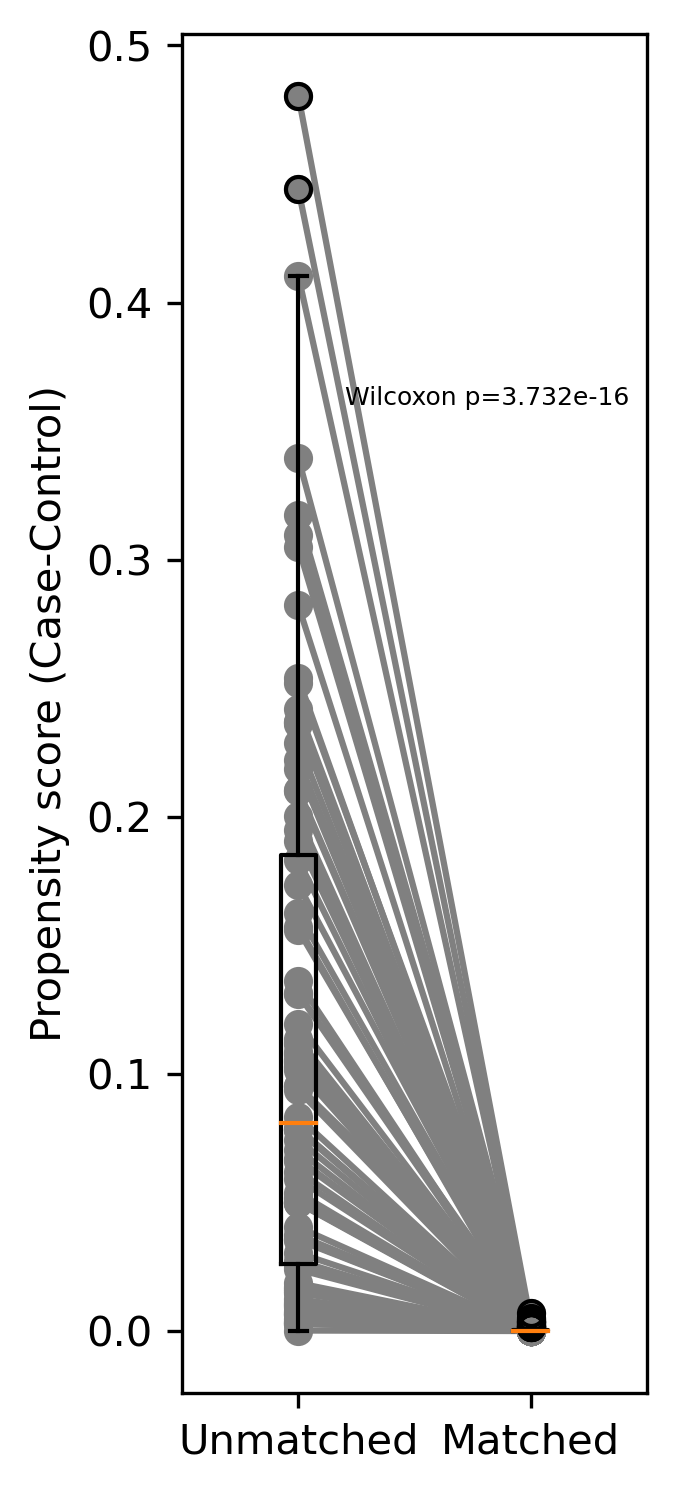

In [6]:
result = []
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    x = matched.loc[matched['Group']==0, 'distance']
    y = matched.loc[matched['Group']==1, 'distance']
    x_matched = matched.loc[pairs['Control'], 'distance']
    y_matched = matched.loc[pairs['Case'], 'distance']
    result.append([project, x.mean(), y.mean(), x_matched.mean(), y_matched.mean(), y.mean() - x.mean(), abs(y_matched.mean() - x_matched.mean())])
result = pd.DataFrame(result, columns=['Project', 'Control', 'Case', 'Control_matched', 'Case_matched', 'Delta_Unmatched', 'Delta_Matched'])
result.head(2)
#result.to_csv('../Results/2.PSMdata.csv')

p = stats.wilcoxon(result['Delta_Unmatched'], result['Delta_Matched'], alternative='two-sided')[1]
print('Wilcoxon p=%.3e' % p)

_ = plt.figure(0, (2, 6), dpi=300)
for i in result.index:
    _ = plt.plot([1, 2], result.loc[i, ['Delta_Unmatched', 'Delta_Matched']], '-o', alpha=1, color='gray')
_ = plt.boxplot([result['Delta_Unmatched'], result['Delta_Matched']])
_ = plt.annotate('Wilcoxon p=%.3e'%p, (1.2, 0.36), fontsize=6)
_ = plt.ylabel('Propensity score (Case-Control)')
_ = plt.xticks([1, 2], ['Unmatched', 'Matched'])
#plt.savefig('../Results/2.psm_boxplot.pdf',bbox_inches = 'tight')
_ = plt.show()

### 2. meaningful features

In [7]:
PS_threshold = 0.05
Features = ['Baseline', 'Case', 'Antibiotic', 'Age', 'Country'] #, 'Site', 'Kit', 'Baseline', 'Case', 

result = []
for project in projects:
    _, site, control, case = projects_message[project]
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    x = matched.loc[matched['Group']==0, 'distance']
    y = matched.loc[matched['Group']==1, 'distance']
    delta_ps = y.mean() - x.mean()
    if 'antibiotics_current_use' in metadata.columns:
        anti = list(set(metadata['antibiotics_current_use'].dropna()))
        anti = 'Mix' if len(anti)>1 else (anti[0] if len(anti)==1 else np.nan)
    else:
        anti = np.nan
    if 'age_category' in metadata.columns:
        age = list(set(metadata['age_category'].dropna()))
        age = 'Mix' if len(age)>1 else (age[0] if len(age)==1 else np.nan)
    else:
        age = np.nan
    if 'country' in metadata.columns:
        country = list(set(metadata['country'].dropna()))
        country = 'Mix' if len(country)>1 else (country[0] if len(country)==1 else np.nan)
    else:
        country = np.nan
    if 'DNA_extraction_kit' in metadata.columns:
        kit = list(set(metadata['DNA_extraction_kit'].dropna()))
        kit = 'Mix' if len(kit)>1 else (kit[0] if len(kit)==1 else np.nan)
    else:
        kit = np.nan
    result.append([delta_ps, site, control, case, anti, age, country, kit])
result = pd.DataFrame(result, columns=['Delta_PS', 'Site', 'Baseline', 'Case', 'Antibiotic', 'Age', 'Country', 'Kit'], 
                      index = projects)
result = result.fillna('NA')
result = result.loc[result['Site']=='stool', :]

### Data Processing
enc = OneHotEncoder()
_ = enc.fit(result[Features])
Onehot_Features = enc.get_feature_names(Features)
encdata = pd.DataFrame(enc.transform(result[Features]).toarray(), columns=Onehot_Features, 
                       index=result.index)
encdata = pd.concat([result[['Delta_PS']], encdata], axis=1, sort=False)
encdata['Delta_PS_01'] = (encdata[['Delta_PS']]>=PS_threshold)+0
encdata[['Delta_PS_01']].groupby('Delta_PS_01').size()
### NA features delete
Onehot_Features = np.array([i for i in Onehot_Features if '_NA' not in i])
encdata = encdata.loc[:, [i for i in encdata.columns if '_NA' not in i]]

encdata.head(2)
#encdata.to_csv('../Results/2.encdata.csv')

Delta_PS_01
0    31
1    50
dtype: int64

,Delta_PS,Baseline_CRC,Baseline_FMT,Baseline_IBD,Baseline_IGT,Baseline_T1D,Baseline_carcinoma_surgery_history,Baseline_control,Baseline_fatty_liver,Baseline_hypertension,...,Country_FRA,Country_GBR,Country_IND,Country_ITA,Country_JPN,Country_LUX,Country_Mix,Country_NLD,Country_USA,Delta_PS_01
08,0.049964,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
100,0.040444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### LASSO model

In [8]:
X = encdata.loc[:, Onehot_Features]
y = np.array(encdata['Delta_PS'])
X.head(2)
alphas, coefs, _ = lasso_path(X, y, eps=1e-4, positive=True) #forces the coefficients to be positive.
neg_log_alphas = -np.log10(alphas)

lasso_path_result = pd.concat([pd.DataFrame({'-log_alpha':neg_log_alphas,}), 
                               pd.DataFrame(coefs.T, columns=Onehot_Features)], axis=1, sort=False)


,Baseline_CRC,Baseline_FMT,Baseline_IBD,Baseline_IGT,Baseline_T1D,Baseline_carcinoma_surgery_history,Baseline_control,Baseline_fatty_liver,Baseline_hypertension,Baseline_migraine,...,Country_DEU,Country_FRA,Country_GBR,Country_IND,Country_ITA,Country_JPN,Country_LUX,Country_Mix,Country_NLD,Country_USA
08,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:

anotas ={'Baseline_control':['Healthy', (1.50, 0.05)], 
         'Case_IBD':['IBD',(4.5,3.5)],
         'Case_ACVD':['ACVD',(4.5,3.5)],
         'Case_T2D':['T2D',(2.25,0.04)],
         'Age_Mix':['Age',(1.6,0.02)],
         'Country_IND':['Country_IND', (4.5, 0.34)], 
         'Country_NLD':['Country_NLD', (4.5, 0.21)], 
         'Case_acute_diarrhoea':['Acute_diarrhoea', (4.5, 0.3)], 
         'Case_cirrhosis':['Cirrhosis', (4.5, 0.125)]}

MannwhitneyuResult(statistic=656.0, pvalue=0.10797897510650743)

MannwhitneyuResult(statistic=25.0, pvalue=0.02212424121883972)

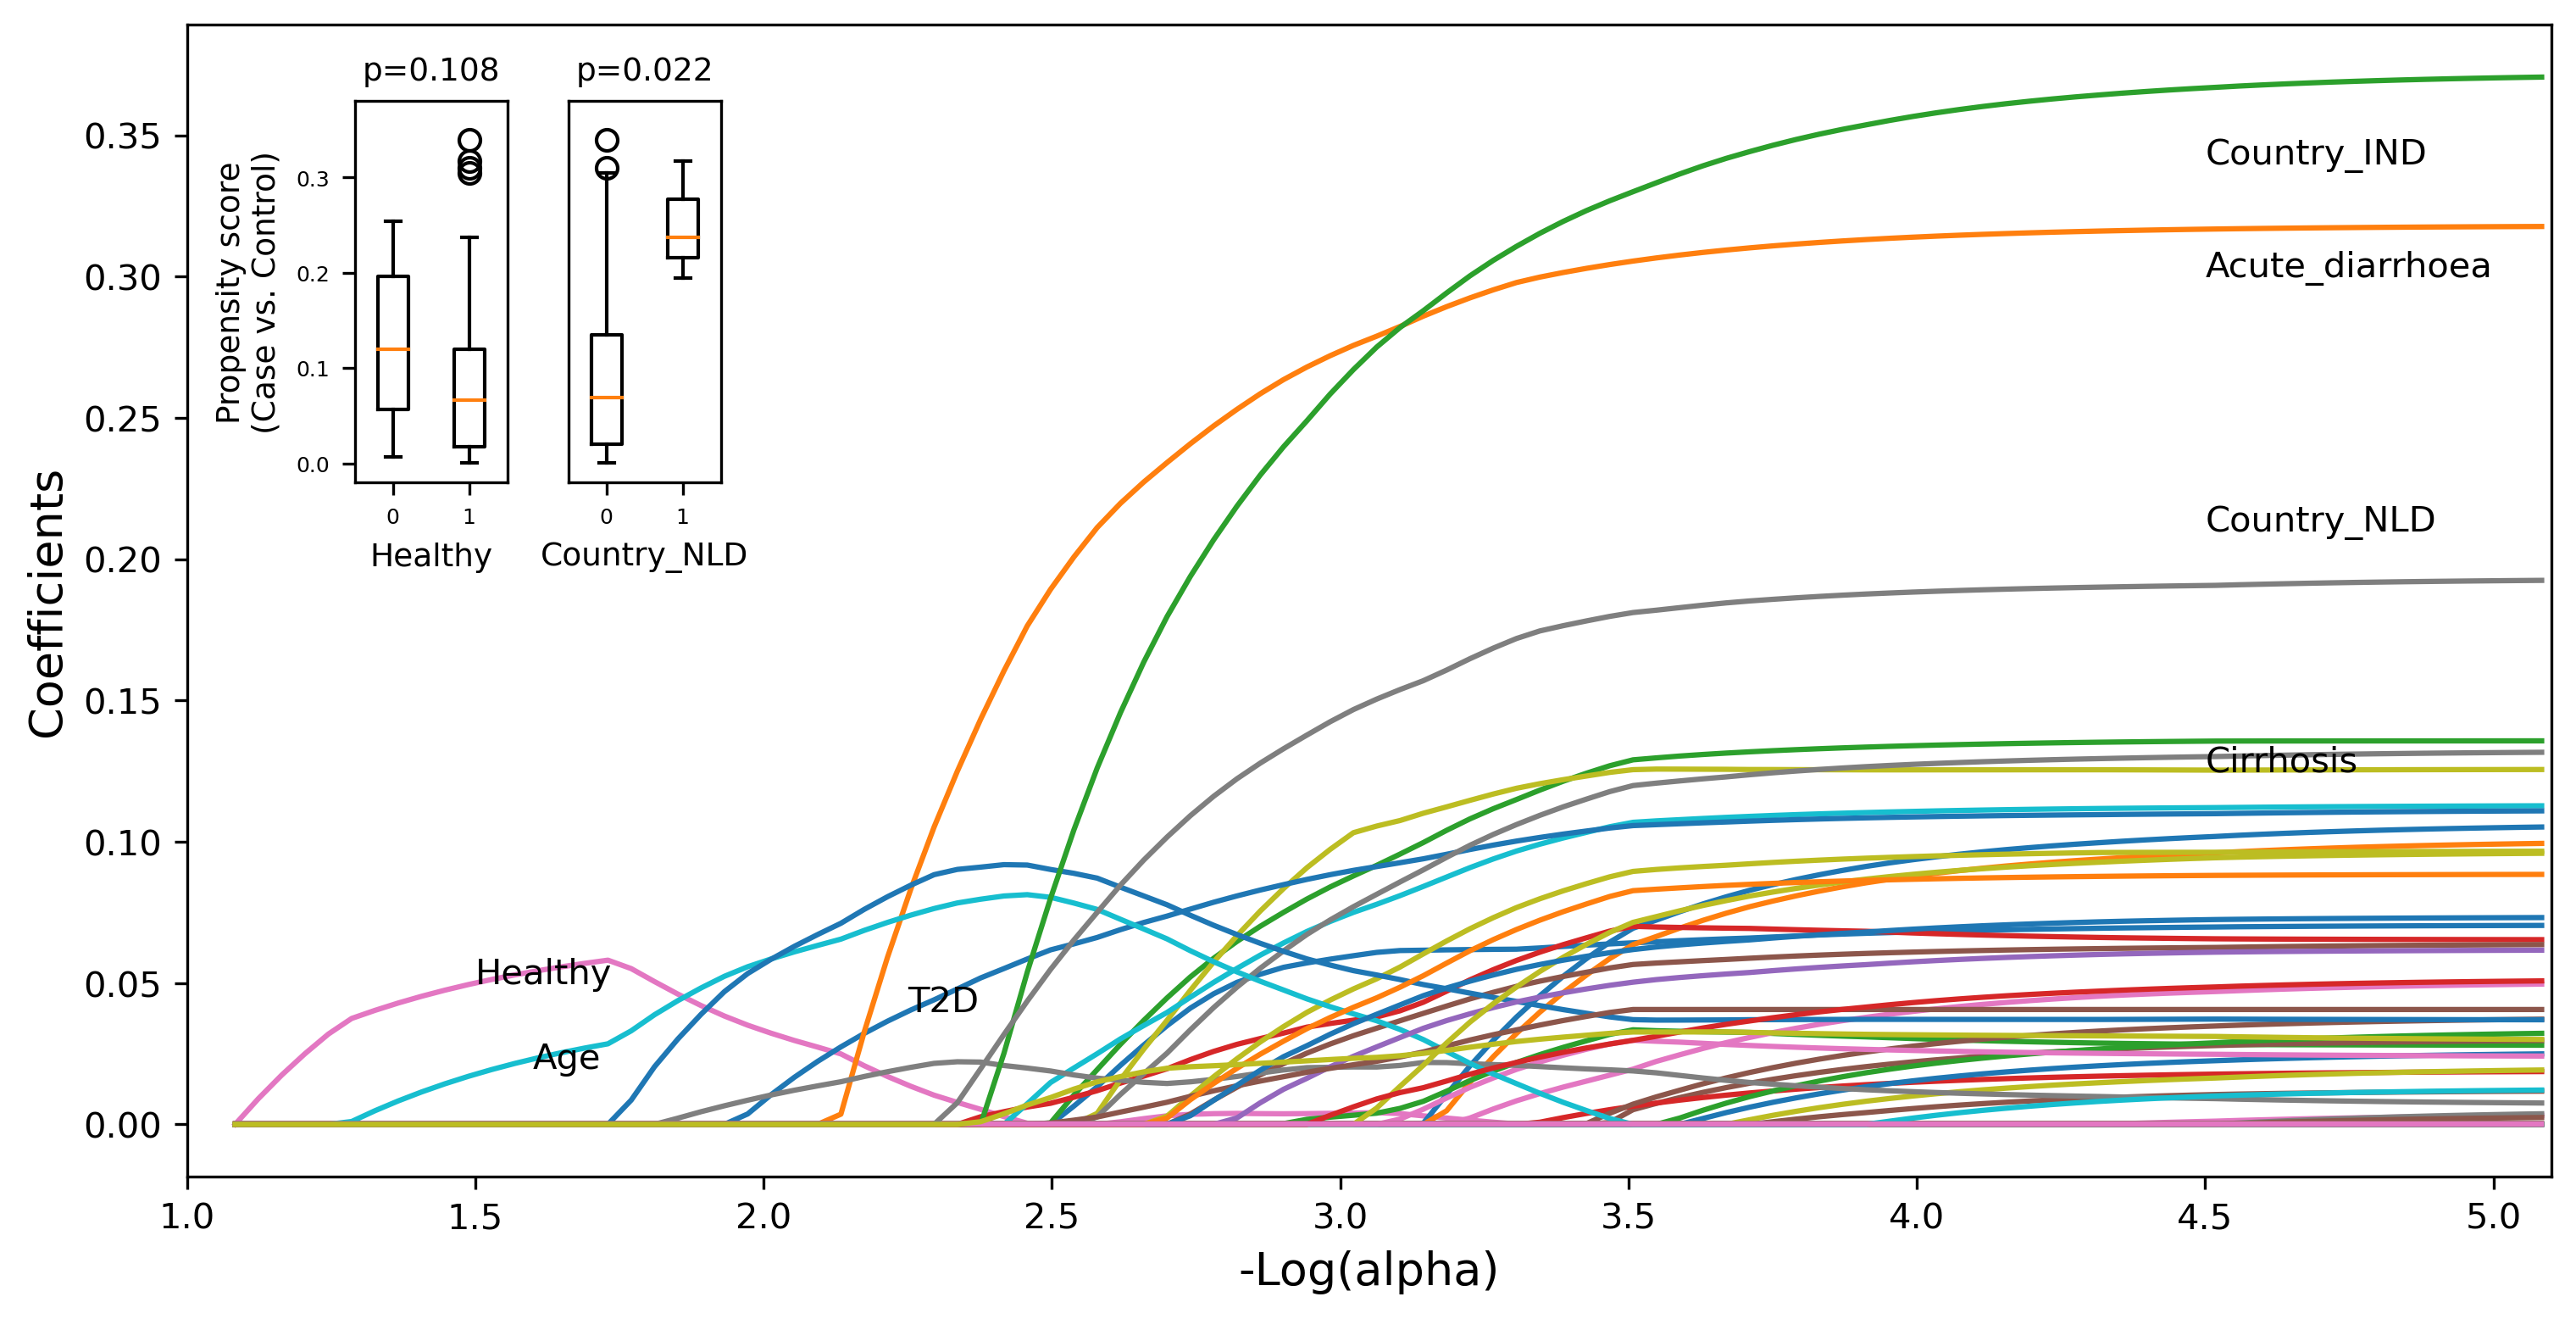

In [10]:
fig = plt.figure(0, (12, 6), dpi=300)
for i in range(len(coefs)):
    _ = plt.plot(neg_log_alphas, coefs[i])
    if coefs[i][np.argmax(coefs[i])]>=0.025:
        if X.columns[i] in anotas.keys():
            s, loc = anotas.get(X.columns[i], [X.columns[i], (neg_log_alphas[np.argmax(coefs[i])], coefs[i][np.argmax(coefs[i])])])
            _ = plt.annotate(s, loc)
_ = plt.xlabel('-Log(alpha)', fontsize=13)
_ = plt.ylabel('Coefficients', fontsize=13)
_ = plt.xlim([1.0, 5.1])

### statisitc
term = 'Baseline_control'
stats.mannwhitneyu(encdata.loc[encdata[term]==0, 'Delta_PS'], encdata.loc[encdata[term]==1, 'Delta_PS'])
left, bottom, width, height = 0.18, 0.58, 0.05, 0.25
ax = fig.add_axes([left,bottom,width,height])
_ = ax.boxplot([encdata.loc[encdata[term]==0, 'Delta_PS'], encdata.loc[encdata[term]==1, 'Delta_PS']], 
                widths=0.4)
_ = plt.xticks([1, 2], [0 ,1], fontsize=6)
_ = plt.yticks(fontsize=6)
_ = plt.ylim([-0.02, 0.38])
_ = ax.set_xlabel(anotas[term][0], fontsize=9)
_ = ax.set_ylabel('Propensity score\n(Case vs. Control)', fontsize=9)
_ = ax.set_title('p=0.108', fontsize=9)

term = 'Country_NLD'
stats.mannwhitneyu(encdata.loc[encdata[term]==0, 'Delta_PS'], encdata.loc[encdata[term]==1, 'Delta_PS'])
left, bottom, width, height = 0.25, 0.58, 0.05, 0.25
ax = fig.add_axes([left,bottom,width,height])
_ = ax.boxplot([encdata.loc[encdata[term]==0, 'Delta_PS'], encdata.loc[encdata[term]==1, 'Delta_PS']], 
                widths=0.4)
_ = plt.xticks([1, 2], [0 ,1], fontsize=6)
_ = plt.yticks([])
_ = plt.ylim([-0.02, 0.38])
_ = ax.set_xlabel(anotas[term][0], fontsize=9)
_ = ax.set_title('p=0.022', fontsize=9)
#plt.savefig('../Results/2.factor_imbalance.pdf',bbox_inches = 'tight')
_ = plt.show()

### 3. age, gender, bmi...Results

In [11]:
fr = open("../Label/Meta_terms.txt",'r+')
Meta_terms = eval(fr.read())   
print(Meta_terms)
fr.close()

{'08': ['age', 'infant_age', 'age_category', 'gender', 'country', 'born_method', 'premature', 'birth_weight', 'gestational_age'], '09': ['age', 'age_category', 'gender', 'country', 'antibiotics_family'], '100': ['age', 'age_category', 'gender', 'country', 'BMI', 'smoker', 'dyastolic_p', 'systolic_p'], '101': ['age', 'age_category', 'gender', 'country', 'BMI'], '11': ['age', 'age_category', 'gender', 'country', 'alcohol', 'flg_genotype'], '15': ['age_category', 'country', 'family', 'disease_subtype', 'body_subsite'], '18_1': ['age', 'age_category', 'gender', 'country', 'BMI', 'disease_subtype', 'triglycerides', 'hdl', 'ldl', 'hba1c'], '18_2': ['age', 'age_category', 'gender', 'country', 'BMI', 'disease_subtype', 'tnm', 'triglycerides', 'hdl', 'ldl', 'hba1c'], '18_3': ['age', 'age_category', 'gender', 'country', 'BMI', 'disease_subtype', 'tnm', 'triglycerides', 'hdl', 'ldl', 'hba1c'], '24_1': ['age_category', 'country', 'body_subsite', 'smoker', 'ever_smoker', 'dental_sample_type', 'hist

In [12]:
def check_type(data):
    types = np.array([type(i)==str for i in data])
    if types.sum()==len(types):
        return 'Cat', data
    elif types.sum()==0:
        return 'Con', data
    else:
        data[types] = np.nan
        return 'Con', data
    
def feature_importance(clf, X, y, times=100):
    result = []
    score_raw = clf.score(X, y)
    for f in X.columns:
        res = []
        for t in range(times):
            X_random = X.copy()
            X_random[f] = np.random.choice(X_random[f], len(X_random[f]), replace=False)
            score_random = clf.score(X_random, y)
            res.append(score_raw - score_random)
        result.append((f, np.array(res).mean()))
    return result

remove_features = ['gender_female', 'gender_NA', 'antibiotics_current_use_no', 'antibiotics_family_NA', 'alcohol_no', 
                   'smoker_no', 'smoker_NA', 'mumps_no']
result = []
feature_set = set([])
importances = {}
for project in Meta_terms.keys():
    _, site, control, case = projects_message[project]
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    ### Data Processing
    data = metadata[Meta_terms[project]].fillna('NA')
    data_col_types = []
    for col in data.columns:
        t, newx = check_type(data[col])
        data[col] = newx
        data_col_types.append(t)
    data_col_types = np.array(data_col_types)
    ### encode
    cat_cols = data_col_types=='Cat'
    enc = OneHotEncoder(handle_unknown='ignore')
    _ = enc.fit(data.loc[:, cat_cols])
    Onehot_Features = enc.get_feature_names(data.columns[cat_cols])
    encdata = pd.DataFrame(enc.transform(data.loc[:, cat_cols]).toarray(), columns=Onehot_Features, 
                           index=data.index)
    data = pd.concat([data.loc[:, data_col_types=='Con'], encdata], axis=1, sort=False)
    ### Missing values
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    data = pd.DataFrame(imp_mean.fit_transform(data.values), index=data.index, columns=data.columns)
    ### Matched data
    #features = ['Group']
    features = data.columns #features.extend(data.columns)
   
    A=data.reset_index()
    B=matched[['Group', 'PC0', 'PC1', 'PC2', 'distance']].reset_index()
    data = pd.concat([A, B], axis=1, sort=False)
    ### Model
    features = list(set(features)-set(remove_features))
    X = data[features]
    y = data['distance']
    clf = LinearRegression(normalize=True).fit(X, y)
    #project, site, control, case, data.shape, clf.score(X, y)
    project, site, control, case, list(zip(features, clf.coef_))
    feature_set.update(features)
    importances[project] = dict(feature_importance(clf, X, y))
    result.append([project, site, control, case, data.shape[0], data.shape[1], clf.score(X, y)])
result = pd.DataFrame(result, columns=['project', 'Site', 'Control', 'Case', 'Sample', 'Feature', 'R2'])


('08',
 'stool',
 'control',
 'premature_born',
 [('premature_yes', -245389792420.05008),
  ('gender_male', -0.0031198456279657423),
  ('gestational_age', 0.0007595647608984864),
  ('birth_weight', -7.614317977779987e-06),
  ('age', -3621837199.4836426),
  ('born_method_c_section', 475746764847.88794),
  ('infant_age', 0.00022645034890666566),
  ('age_category_newborn', 0.001953125),
  ('born_method_vaginal', 475746764847.88995),
  ('born_method_NA', 115178486213.89517),
  ('country_USA', 0.0),
  ('premature_no', 115178486213.89517)])

('09',
 'oralcavity',
 'control',
 'schizofrenia',
 [('antibiotics_family_thienobenzodiazepines', 0.3124040002860009),
  ('gender_male', -0.07872744107955316),
  ('antibiotics_family_dopamine_antagonists;thienobenzodiazepines',
   -0.15368130666100605),
  ('age_category_adult', -2.0816681711721685e-17),
  ('age', -0.0014903830548276605),
  ('antibiotics_family_dopamine_antagonists', 0.1764406371541148),
  ('antibiotics_family_phenylpiperidines;thienobenzodiazepines',
   0.16136029274266345),
  ('antibiotics_family_dopamine_antagonists;phenylpiperidines',
   0.3111682234306405),
  ('country_USA', 0.0)])

('100',
 'stool',
 'control',
 'schizofrenia',
 [('BMI', 0.0012538308759772005),
  ('gender_male', -0.005929187077160416),
  ('smoker_yes', -0.01749364789424495),
  ('age_category_adult', -0.01669365443964135),
  ('age', 0.000619977747435704),
  ('systolic_p', 0.0014328861161559423),
  ('age_category_schoolage', 0.01669365443964165),
  ('country_CHN', 0.0),
  ('dyastolic_p', -0.0009058643443647608)])

('101',
 'stool',
 'control',
 'ME/CFS',
 [('BMI', 0.004231953084944394),
  ('gender_male', -0.03294560491399684),
  ('age_category_adult', 0.0),
  ('age', 0.0),
  ('country_USA', 0.0)])

('11',
 'skin',
 'control',
 'AD',
 [('flg_genotype_s1515x', -0.047919803589284514),
  ('gender_male', -0.0869373936363269),
  ('country_BRN', -0.13316387054883427),
  ('country_SGP', 0.035735606233669275),
  ('flg_genotype_wt', -0.015379216156115845),
  ('age_category_adult', 0.0),
  ('age', -0.004650087273316486),
  ('alcohol_yes', -0.04053370981104367),
  ('country_CHN', 0.028068346212413903),
  ('flg_genotype_e2422x', 0.05332947511232751),
  ('country_MYS', -0.1797349470857176),
  ('country_IDN', 0.23506832045436377),
  ('flg_genotype_e2422x/3321dela', 0.03829967965749729)])

('15',
 'stool',
 'control',
 'acute_diarrhoea',
 [('family_DavidLA_2015_11', 0.3066684345367747),
  ('family_DavidLA_2015_3', 0.163689991603311),
  ('family_DavidLA_2015_1', -0.4315920491424122),
  ('family_DavidLA_2015_2', 0.09664013834046126),
  ('family_DavidLA_2015_5', -0.2226794587716698),
  ('body_subsite_rectal_swab', -0.06906368975058448),
  ('family_DavidLA_2015_7', -0.0008232475707170345),
  ('family_DavidLA_2015_9', 0.1299676144463312),
  ('country_BGD', -4.163336342344337e-17),
  ('disease_subtype_healthy', -0.15465021249143238),
  ('age_category_adult', 0.02177301487695307),
  ('family_DavidLA_2015_4', -0.0021298357251469777),
  ('age_category_child', -0.02177301487695307),
  ('disease_subtype_cholera', 0.15465021249143227),
  ('body_subsite_stool', 0.06906368975058437),
  ('family_DavidLA_2015_10', 0.1668954968631212),
  ('family_DavidLA_2015_6', 0.05274371653784893),
  ('family_DavidLA_2015_8', -0.27186392138549215),
  ('family_DavidLA_2015_12', 0.04594679334491147)])

('18_1',
 'stool',
 'control',
 'adenoma',
 [('BMI', 0.001641798371862947),
  ('gender_male', -0.008477784269510413),
  ('hba1c', 0.00213379654507921),
  ('country_AUT', -3.469446951953614e-18),
  ('hdl', -0.000330592648730405),
  ('age_category_senior', 0.007331663441609188),
  ('age_category_adult', -0.007331663441609211),
  ('age', -0.0025223510132203236),
  ('triglycerides', -4.401136690697374e-05),
  ('disease_subtype_advancedadenoma', 0.002586009467472864),
  ('disease_subtype_NA', -0.002586009467472862),
  ('ldl', 2.455659428779281e-05)])

('18_2',
 'stool',
 'control',
 'CRC',
 [('tnm_t4n2m0', -0.008778671823326275),
  ('disease_subtype_NA', -0.07385933135970037),
  ('ldl', 0.00011681087241563684),
  ('tnm_t2n0m0', -0.06490095776972722),
  ('tnm_t4n1m1', 0.05604122767430087),
  ('age', -0.005405219626946213),
  ('tnm_t3n2m0', 0.2088880255341742),
  ('tnm_NA', -0.02740925284047724),
  ('tnm_t1n0m0', -0.05716868703696449),
  ('gender_male', -0.022489388659515257),
  ('tnm_t3n1m0', 0.00024897357696602665),
  ('tnm_t4n1m0', 0.22156343206415738),
  ('country_AUT', -2.0816681711721685e-17),
  ('hdl', -0.0021784700097659503),
  ('age_category_senior', 0.033567475133198785),
  ('age_category_adult', -0.03356747513319887),
  ('tnm_ptis', 0.07906146121304534),
  ('BMI', -0.0069854557148640506),
  ('hba1c', 0.022128313622364258),
  ('tnm_t3n0m0', 0.008345888044645113),
  ('tnm_t4n0m0', 0.21577573147614582),
  ('triglycerides', -0.00048309312137287635),
  ('disease_subtype_carcinoma', 0.07385933135970037)])

('18_3',
 'stool',
 'CRC',
 'adenoma',
 [('disease_subtype_advancedadenoma', 0.11215363762231245),
  ('tnm_t4n2m0', 0.09356241019265295),
  ('ldl', -0.0012333738142963004),
  ('tnm_t2n0m0', 0.07950016626198565),
  ('tnm_t4n1m1', 0.011855183734910575),
  ('age', 0.001155249669798186),
  ('tnm_t3n2m0', -0.21761845166152152),
  ('tnm_NA', -0.02627962498611817),
  ('tnm_t1n0m0', 0.08284037918764413),
  ('gender_male', 0.08550225112650314),
  ('tnm_t3n1m0', -0.006007544831579897),
  ('tnm_t4n1m0', -0.12238995252884394),
  ('country_AUT', -1.3877787807814457e-16),
  ('hdl', 0.002863905538081447),
  ('age_category_senior', 0.01058617047793243),
  ('age_category_adult', -0.010586170477932392),
  ('tnm_ptis', -0.019492815375153617),
  ('BMI', -0.0012358913593832586),
  ('hba1c', -0.0362007872571747),
  ('tnm_t3n0m0', 0.009537764333990255),
  ('tnm_t4n0m0', -0.08082877673694201),
  ('triglycerides', 0.0006349243163766192),
  ('disease_subtype_carcinoma', -0.11215363762231238)])

('24_1',
 'oralcavity',
 'control',
 'mucositis',
 [('history_of_periodontitis_NA', 0.07063931277372555),
  ('PPD_D', 0.009662056490112765),
  ('dental_sample_type_implant', 0.03471179652934514),
  ('dental_sample_type_teeth', -0.03471179652934517),
  ('PPD_B', 0.03302178517208363),
  ('country_ITA', 6.245004513516506e-17),
  ('smoker_yes', 0.03516948400748053),
  ('age_category_adult', -1.1102230246251565e-16),
  ('ever_smoker_yes', 0.03357979148634377),
  ('history_of_periodontitis_yes', -0.022044576306495076),
  ('ever_smoker_no', -0.015984017986913217),
  ('PPD_L', -0.029406302406497067),
  ('body_subsite_subgingival_plaque', 0.0),
  ('ever_smoker_NA', -0.10861299977711446),
  ('PPD_M', 0.020785309279846172),
  ('history_of_periodontitis_no', 0.0029480313698137784)])

('24_2',
 'oralcavity',
 'mucositis',
 'peri-implantitis',
 [('history_of_periodontitis_NA', -0.1332214659335523),
  ('PPD_D', 0.0009743739679573763),
  ('dental_sample_type_implant', 1.1102230246251565e-16),
  ('PPD_B', 0.029453990211530997),
  ('country_ITA', 2.7755575615628914e-16),
  ('smoker_yes', -0.10018618871692388),
  ('age_category_adult', 0.0),
  ('ever_smoker_yes', 0.022642891328864878),
  ('history_of_periodontitis_yes', 0.02920800204970692),
  ('ever_smoker_no', -0.051503357184782446),
  ('PPD_L', 0.00760776694409335),
  ('body_subsite_subgingival_plaque', 0.0),
  ('ever_smoker_NA', 0.16163987216525122),
  ('PPD_M', -0.01786080349799847),
  ('history_of_periodontitis_no', 0.005774300816796238)])

('24_3',
 'oralcavity',
 'control',
 'peri-implantitis',
 [('history_of_periodontitis_NA', 0.04425843040039614),
  ('PPD_D', 0.020406341336139076),
  ('dental_sample_type_implant', 0.01454895508973738),
  ('dental_sample_type_teeth', -0.014548955089737376),
  ('PPD_B', 0.03296118513166656),
  ('country_ITA', 0.0),
  ('smoker_yes', -0.05712655518014068),
  ('age_category_adult', 8.326672684688674e-17),
  ('ever_smoker_yes', 0.0245138431236163),
  ('history_of_periodontitis_yes', -0.005269992238316766),
  ('ever_smoker_no', -0.010723725621106366),
  ('PPD_L', -0.021266626323685624),
  ('body_subsite_subgingival_plaque', 0.0),
  ('ever_smoker_NA', -0.08444399988357877),
  ('PPD_M', 0.023313398580463197),
  ('history_of_periodontitis_no', -0.0075384477818832)])

('26',
 'stool',
 'control',
 'CRC',
 [('tnm_t2n2m0', 0.17383250507134354),
  ('tnm_t2n0m1', 0.19100707791277868),
  ('tnm_t4n2m0', 0.11951711551291902),
  ('disease_subtype_NA', -0.047722292904380466),
  ('tnm_t2n0m0', 0.12226106216455751),
  ('country_IND', 4.163336342344337e-17),
  ('fobt_NA', -0.04772229290438047),
  ('age', 0.0038135478418049405),
  ('population_Kerala', 0.08760692781727701),
  ('tnm_t3n2m0', -0.06788604645881476),
  ('tnm_NA', -0.04772229290438045),
  ('fobt_yes', 0.04772229290438045),
  ('tnm_t1n0m0', 0.11029045229695791),
  ('gender_male', -0.030488288119966327),
  ('tnm_t4n1m0', -0.11329816974776862),
  ('age_category_senior', 0.027435831221657443),
  ('age_category_adult', -0.027435831221657454),
  ('population_Bhopal', -0.08760692781727704),
  ('BMI', -0.02085987898596336),
  ('tnm_t2m0n0', 0.19184259888829536),
  ('tnm_t3n0m0', 0.22206063657919606),
  ('disease_subtype_adenocarcinoma', 0.047722292904380445)])

('27',
 'stool',
 'control',
 'IBD',
 [('disease_subtype_UC', 15211417120783.44),
  ('HBI', 0.003426265279292768),
  ('country_USA', -2362933282101.6426),
  ('calprotectin', -4.21019646579767e-05),
  ('age_category_adult', -32296446087.78125),
  ('disease_subtype_NA', 15211417120783.432),
  ('disease_subtype_CD', 15211417120783.5),
  ('SCCAI', -0.003660542509413101)])

('28_1',
 'stool',
 'control',
 'adenoma',
 [('country_CAN', 0.0674096558646117),
  ('BMI', 0.001698494002202304),
  ('gender_male', 0.05717052947175288),
  ('fobt_no', 0.052550179169963886),
  ('age_category_senior', 0.0004912272481733092),
  ('age_category_adult', -0.0004912272481733112),
  ('age', 0.0021736846700667937),
  ('fobt_yes', -0.05255017916996387),
  ('country_USA', -0.06740965586461176)])

('28_2',
 'stool',
 'control',
 'CRC',
 [('country_CAN', -0.12585038743265858),
  ('BMI', -0.0004281216339709742),
  ('gender_male', 0.008060781590801378),
  ('fobt_no', -0.07236190430808642),
  ('age_category_senior', 0.012981120242089134),
  ('age_category_adult', -0.012981120242089111),
  ('age', 0.0029271231238770694),
  ('fobt_yes', 0.07236190430808642),
  ('country_USA', 0.12585038743265864)])

('28_3',
 'stool',
 'CRC',
 'adenoma',
 [('country_CAN', 0.07889554072417795),
  ('BMI', 0.0030081676041654173),
  ('gender_male', -0.05593666143674239),
  ('fobt_no', 0.03875485126505862),
  ('age_category_senior', -0.00234864794168672),
  ('age_category_adult', 0.002348647941686688),
  ('age', 0.0007997357326665684),
  ('fobt_yes', -0.038754851265058635),
  ('country_USA', -0.0788955407241779)])

('30',
 'stool',
 'control',
 'T1D',
 [('antibiotics_family_blood_pressure_medication;diabetes_oral_medication',
   -0.14810608625750057),
  ('BMI', 0.0007559192065819782),
  ('gender_male', -0.019431766592332693),
  ('cholesterol', -0.0004877828904803558),
  ('age_category_adult', 0.0005424955398851579),
  ('age', -0.00027060118635053215),
  ('age_category_schoolage', -0.013058017496238474),
  ('antibiotics_family_diabetes_oral_medication', 0.029539106907052973),
  ('country_LUX', -5.551115123125783e-17),
  ('antibiotics_family_blood_pressure_medication', -0.1471209138849014),
  ('c_peptide', 0.014749248207661624),
  ('mumps_yes', 0.09204813370602284),
  ('days_from_first_collection', 6.104844290306611e-05),
  ('glucose', -0.00011377459591155998),
  ('age_category_child', 0.019975534291055173)])

('36',
 'stool',
 'control',
 'IBD',
 [('BMI', -0.0008769645388925165),
  ('gender_male', -0.00538386428958253),
  ('disease_subtype_UC', 1191041067215.6404),
  ('country_USA', -1944022106225.746),
  ('age_category_senior', -2601094142913.995),
  ('age_category_adult', -2601094142913.9946),
  ('age', 0.00035751362068497754),
  ('age_category_schoolage', -2601094142913.9834),
  ('disease_subtype_NA', 1191041067215.633),
  ('disease_subtype_CD', 1191041067215.6462),
  ('age_category_child', -2601094142913.9863)])

('37_1',
 'stool',
 'control',
 'IGT',
 [('population_Hispanic_Latino', 299162131.5068666),
  ('hemoglobinometry', -0.030532573949825084),
  ('hscrp', -0.0023591851371156883),
  ('creatinine', 0.0029728659107716906),
  ('urea_nitrogen', 0.007956655852877926),
  ('glucose', -0.0009889316708895706),
  ('country_USA', -53231029052.13916),
  ('ldl', -0.055311212427117756),
  ('alt', 0.0010493265906823485),
  ('age', 0.00298989065934783),
  ('gender_male', -0.0259297448854951),
  ('prothrombin_time', -319179676082.719),
  ('cholesterol', 0.054572528027304966),
  ('bilubirin', -0.001950226715598034),
  ('population_Caucasian', 299162131.59418684),
  ('antibiotics_family_cephalosporins', -0.15220668264231438),
  ('hdl', -0.053360588014271015),
  ('age_category_senior', -4246993397.501463),
  ('age_category_adult', -4246993397.389825),
  ('albumine', 31917967608.264374),
  ('rbc', 0.09808701866678596),
  ('globulin', 31917967608.277737),
  ('hba1c', 0.018752495369565792),
  ('wbc', 0.006326419

('37_2',
 'stool',
 'IGT',
 'T2D',
 [('population_Hispanic_Latino', -0.003163997880653914),
  ('hemoglobinometry', -0.000996406288141376),
  ('hscrp', -0.0009007539420561757),
  ('creatinine', 0.0005727939587219507),
  ('urea_nitrogen', -0.0006369133533874642),
  ('glucose', -0.00025883449557075354),
  ('country_USA', 11342594878687.402),
  ('ldl', -0.013917372092433737),
  ('alt', 7.787811059210107e-05),
  ('age', 0.0004230584740624528),
  ('gender_male', 0.026448169052464065),
  ('prothrombin_time', 19305411977385.6),
  ('cholesterol', 0.013790278215447814),
  ('bilubirin', 0.04051932466370571),
  ('population_Caucasian', 0.009970981330369937),
  ('hdl', -0.01268926417729151),
  ('age_category_senior', 2224589881915.4814),
  ('age_category_adult', 2224589881915.5205),
  ('albumine', -1930541197738.5637),
  ('rbc', -0.026186985982820758),
  ('globulin', -1930541197738.5574),
  ('hba1c', 0.018289920281186742),
  ('wbc', 4.493645307930626e-05),
  ('population_Asian', -0.0185020180636267

('37_3',
 'stool',
 'control',
 'T2D',
 [('population_Hispanic_Latino', -0.16767979806364658),
  ('hemoglobinometry', -0.1770456676297134),
  ('hscrp', -0.06050270521350651),
  ('creatinine', -0.0032856664196933803),
  ('urea_nitrogen', -0.015254339957084445),
  ('glucose', -0.004690937219069093),
  ('country_USA', 2.6367796834847468e-14),
  ('ldl', 0.07393120397235611),
  ('alt', 0.034057955780073),
  ('age', 0.019211299304120577),
  ('gender_male', 0.1953774035260534),
  ('prothrombin_time', -0.029680599434697984),
  ('cholesterol', -0.07274362897737756),
  ('bilubirin', -0.026023057815296752),
  ('population_Caucasian', 0.06400102283784677),
  ('antibiotics_family_cephalosporins', 0.18115623148307794),
  ('hdl', 0.08424994095648156),
  ('age_category_adult', -1.554312234475219e-14),
  ('albumine', -0.0053494113769482566),
  ('rbc', 0.5808153784869294),
  ('globulin', -0.0003196215300723282),
  ('hba1c', -0.2048872944813517),
  ('wbc', 0.04120213335558441),
  ('population_Asian', -0.

('38',
 'stool',
 'control',
 'IBD',
 [('family_IjazUZ_2017_9', 50332169640992.29),
  ('treatment_probiotic', 3682173995596.538),
  ('family_IjazUZ_2017_35', 1027123178884.6891),
  ('family_IjazUZ_2017_37', 1027123178884.6616),
  ('family_role_mother', -1185447477414.1824),
  ('family_IjazUZ_2017_11', 3257121748487.1255),
  ('family_IjazUZ_2017_8', 3257121748487.5845),
  ('treatment_iron', 3682173995596.7466),
  ('disease_subtype_NA', 281370396302.75104),
  ('family_IjazUZ_2017_10', 3257121748486.882),
  ('family_IjazUZ_2017_45', 1027123178883.959),
  ('family_IjazUZ_2017_34', 1027123178883.8091),
  ('treatment_5-ASA;aza', 3682173995596.414),
  ('family_IjazUZ_2017_52', 925443254161.4589),
  ('family_role_NA', 1044551092189.0083),
  ('age', 0.038159951108109956),
  ('family_IjazUZ_2017_47', 1027123178883.7239),
  ('family_IjazUZ_2017_43', 1027123178884.1558),
  ('disease_subtype_CD', -516603155006.9796),
  ('treatment_aza;iron;EEN', 3682173995596.1006),
  ('family_IjazUZ_2017_6', 32571

('39',
 'stool',
 'control',
 'ACVD',
 [('BMI', -0.0017012171237649888),
  ('cholesterol', -0.0001892647224663296),
  ('hba1c', 0.0031847320675384397),
  ('age_category_senior', 0.0026334161755890923),
  ('hdl', -0.0012108688914293365),
  ('age_category_adult', -0.002633416175589095),
  ('age', 0.0005627975677795358),
  ('systolic_p', 0.0014019687464844376),
  ('country_CHN', -5.551115123125783e-17),
  ('triglycerides', 4.63567960358966e-05),
  ('smoker_yes', 0.0696167073577651),
  ('creatinine', 0.0006016904479817321),
  ('urea_nitrogen', 0.004245136485932905),
  ('dyastolic_p', -0.0009709239476956731),
  ('ldl', -0.0006341469992804256)])

('40_1',
 'stool',
 'control',
 'IGT',
 [('country_SVK', -0.10936308853021173),
  ('country_ISL', -0.11333690351650204),
  ('hscrp', 0.0013602712957331683),
  ('country_FRA', 0.08514121476517333),
  ('c_peptide', 0.05487607769487033),
  ('creatinine', 0.00010083276834566845),
  ('ldl', -0.12748594491593132),
  ('country_NOR', 0.09096187784044023),
  ('adiponectin', -0.0025294586352859116),
  ('age', -0.006640623252003435),
  ('leptin', -5.37871836184092e-05),
  ('insulin_cat_no', 5.2735593669694936e-14),
  ('glutamate_decarboxylase_2_antibody', 0.00353336670846142),
  ('country_SWE', 0.007444963924994287),
  ('cholesterol', 0.04911646316149538),
  ('hdl', -0.12226801247964887),
  ('age_category_senior', -2.886579864025407e-13),
  ('BMI', -0.002229751536481691),
  ('hba1c', 0.0012642585889815771),
  ('triglycerides', -0.010947405371038195),
  ('country_DEU', 0.0530215510720088)])

('40_2',
 'stool',
 'IGT',
 'T2D',
 [('country_SVK', -0.016501258778696914),
  ('hscrp', -0.0005669580575944881),
  ('c_peptide', 0.003288685866461743),
  ('country_FIN', -0.008154964210305753),
  ('creatinine', -0.0006889718841355468),
  ('ldl', 0.05620192448465434),
  ('country_HUN', 0.06454902915978676),
  ('country_NOR', -0.011493618137664821),
  ('adiponectin', -0.0014043439090149418),
  ('age', 0.016569248229593467),
  ('leptin', 0.0009489637600631593),
  ('country_EST', 0.018656154411670862),
  ('insulin_cat_no', 0.03887541761984133),
  ('glutamate_decarboxylase_2_antibody', -0.0017768567510453841),
  ('country_SWE', 0.03953746768988973),
  ('cholesterol', -0.02141898374189722),
  ('insulin_cat_yes', -0.03887541761990388),
  ('hdl', 0.05755832581927186),
  ('age_category_senior', 3.9968028886505635e-14),
  ('BMI', 0.001580271533125441),
  ('hba1c', 0.002236255787042801),
  ('country_DNK', -0.08009935462443793),
  ('triglycerides', 0.005570020869684602),
  ('country_DEU', -0.1253

('40_3',
 'stool',
 'control',
 'T2D',
 [('country_SVK', 0.2224098196938396),
  ('country_ISL', -0.159959064467918),
  ('hscrp', 0.0007368734933926648),
  ('country_FRA', 0.1637892650988952),
  ('c_peptide', 0.00785630182821458),
  ('country_FIN', -0.048603351914084665),
  ('creatinine', -0.0003446701829707714),
  ('ldl', -0.02369310550534532),
  ('country_HUN', 0.09262624225464254),
  ('age', 0.02451226832959951),
  ('country_EST', 0.16867157978638705),
  ('insulin_cat_no', -0.01657258086880462),
  ('glutamate_decarboxylase_2_antibody', -0.010851182973576852),
  ('country_SWE', -0.03829514221738026),
  ('cholesterol', 0.008707344134498446),
  ('insulin_cat_yes', 0.01657258086885236),
  ('hdl', -0.02302392643470974),
  ('age_category_senior', -2.9976021664879227e-15),
  ('BMI', 0.0025731661599042144),
  ('hba1c', -0.000288277637971561),
  ('country_DNK', -0.07176181340620337),
  ('triglycerides', -0.0018815909803835348),
  ('country_DEU', 0.028244423050462274)])

('43',
 'stool',
 'control',
 'acute_diarrhoea',
 [('country_BGD', 0.0), ('age_category_child', 0.0)])

('44',
 'stool',
 'control',
 'T1D',
 [('HLA_DQA1*05/*03-DQB1*02/*0301', -0.10032531527693356),
  ('HLA_DQB1*0302/*0*01-DRB1*0401', 0.13450194110288674),
  ('HLA_DQA1*05/*03-DQB1*02/*0302-DRB1*0401', -0.006857092804957831),
  ('HLA_DQB1*0302/*04-DRB1*0401', -0.02700056829274321),
  ('country_FIN', 0.03913400781073227),
  ('feeding_practice_mixed_feeding', -0.07197611823902844),
  ('HLA_DQB1*0302/*0501-DRB*0401', -0.03953838417724628),
  ('HLA_DQA1*05-DQB1*02/*0604', 0.1379190593470027),
  ('HLA_DQA1*05/*0201-DQB1*02/*02', -0.061616862858093605),
  ('age', 0.01220962598469721),
  ('country_EST', -0.03913400781073226),
  ('infant_age', -3.649520530513189e-05),
  ('gender_male', 0.0425427412238286),
  ('HLA_DQB1*0302/*0501-DRB1*0401', -0.008666621540265984),
  ('HLA_DQA1*0201/*03-DQB1*02/*0302-DRB1*0404', 0.05369358095039444),
  ('HLA_DQB1*0302/*0501-DRB1*0404', -0.0864351704303053),
  ('age_category_newborn', -0.0013305010324745838),
  ('born_method_vaginal', -0.07447876199927055),
  ('f

('48_1',
 'stool',
 'control',
 'IBD',
 [('BMI', 0.0013630723268151608),
  ('gender_male', 0.014300801747090546),
  ('country_ESP', -103256889895.16284),
  ('disease_subtype_UC', -78653629852.8337),
  ('country_DNK', -146375433206.9417),
  ('age_category_senior', 1290683264721.5437),
  ('age_category_adult', 1290683264721.5715),
  ('age', 0.0008266946288742451),
  ('country_CHN', -146375433206.92264),
  ('disease_subtype_NA', -35535086541.068184),
  ('disease_subtype_CD', -78653629852.8207)])

('48_2',
 'stool',
 'IBD',
 'T1D',
 [('BMI', -0.0022392383337077964),
  ('fasting_insulin', -0.003074579473349541),
  ('country_ESP', -3621258464579.5537),
  ('gender_male', -0.07863064902830524),
  ('hba1c', 0.028174997448217227),
  ('disease_subtype_UC', 6600206868.392735),
  ('country_DNK', -1869817880606.6875),
  ('age_category_senior', -47782277016745.28),
  ('age_category_adult', -47782277016745.484),
  ('age', -0.002738446419055638),
  ('fasting_glucose', 0.00899510609091976),
  ('disease_subtype_NA', -1744840377104.282),
  ('disease_subtype_CD', 6600206868.294142)])

('48_3',
 'stool',
 'IBD',
 'T2D',
 [('BMI', -0.00485165798235239),
  ('fasting_insulin', 0.0005297448868264546),
  ('country_ESP', -1021459418694.933),
  ('gender_male', -0.07634995700435099),
  ('hba1c', 0.006508220635829539),
  ('disease_subtype_UC', -610068328116.193),
  ('country_DNK', -458943189378.6023),
  ('age_category_senior', -108641796752766.75),
  ('age_category_adult', -108641796752767.02),
  ('age', -0.003746707194325144),
  ('country_CHN', -458943189378.7325),
  ('treatment_metformin', 394457157680.61975),
  ('disease_subtype_NA', -1172584557432.3494),
  ('fasting_glucose', -0.019929526249824914),
  ('treatment_NA', 394457157680.5697),
  ('disease_subtype_CD', -610068328116.266)])

('48_4',
 'stool',
 'T1D',
 'T2D',
 [('BMI', 0.0017036483390706065),
  ('fasting_insulin', 0.0022717795220044924),
  ('hba1c', -0.005919760542776445),
  ('country_DNK', -0.07553372063535653),
  ('age_category_adult', 0.0),
  ('country_CHN', 0.07553372063535652),
  ('treatment_metformin', 0.03415828346531375),
  ('age_NA', 0.0),
  ('fasting_glucose', -0.001319808591884194),
  ('treatment_NA', -0.03415828346531378)])

('48_5',
 'stool',
 'control',
 'T1D',
 [('BMI', 0.003510844038532792),
  ('fasting_insulin', -0.0049771976755546305),
  ('hba1c', 0.02603880330397208),
  ('country_DNK', 0.15585557712184525),
  ('age_category_adult', -1.1102230246251565e-16),
  ('country_CHN', -0.15585557712184528),
  ('age_NA', 0.0),
  ('fasting_glucose', -0.0016561283208467142)])

('48_6',
 'stool',
 'control',
 'T2D',
 [('BMI', -0.0016202989657167946),
  ('fasting_insulin', 0.0008000507663162004),
  ('hba1c', 0.00048406758355500176),
  ('country_DNK', 0.03051181453371646),
  ('age_category_adult', 0.0),
  ('country_CHN', -0.030511814533716455),
  ('treatment_metformin', 0.00784850983209551),
  ('age_NA', 0.0),
  ('fasting_glucose', -0.00523139160103436),
  ('treatment_NA', -0.007848509832095531)])

('49_1',
 'stool',
 'control',
 'hypertension',
 [('country_CHN', 0.0), ('age_category_adult', 0.0)])

('49_2',
 'stool',
 'hypertension',
 'pre-hypertension',
 [('country_CHN', 0.0), ('age_category_adult', 0.0)])

('49_3',
 'stool',
 'control',
 'pre-hypertension',
 [('country_CHN', 0.0), ('age_category_adult', 0.0)])

('50_1',
 'stool',
 'control',
 'FMT',
 [('country_NLD', 0.0), ('gender_male', 0.0), ('age_category_adult', 0.0)])

('50_2',
 'stool',
 'FMT',
 'metabolic_syndrome',
 [('country_NLD', 0.0), ('gender_male', 0.0), ('age_category_adult', 0.0)])

('50_3',
 'stool',
 'control',
 'metabolic_syndrome',
 [('country_NLD', 0.0), ('gender_male', 0.0), ('age_category_adult', 0.0)])

('54_1',
 'stool',
 'control',
 'cirrhosis',
 [('age_category_senior', 0.031203262462250143),
  ('age_category_adult', -0.03120326246225013),
  ('disease_subtype_cirrhosis', 0.03120326246225013),
  ('disease_stage', 0.007800815615562532),
  ('disease_subtype_NAFLD', -0.031203262462250123),
  ('country_USA', 0.0)])

('54_2',
 'stool',
 'control',
 'fatty_liver',
 [('country_USA', 0.0),
  ('age_category_senior', -0.017395160142224607),
  ('age_category_adult', 0.01739516014222459),
  ('disease_stage', 0.012116398165423235),
  ('disease_subtype_NAFLD', 0.0)])

('54_3',
 'stool',
 'fatty_liver',
 'cirrhosis',
 [('age_category_senior', 0.03755041655623418),
  ('age_category_adult', -0.03755041655623419),
  ('disease_subtype_cirrhosis', 0.04341013146599015),
  ('disease_stage', -0.02266628881684709),
  ('disease_subtype_NAFLD', -0.04341013146599014),
  ('country_USA', 0.0)])

('58',
 'stool',
 'control',
 'ME/CFS',
 [('BMI', 0.004231953084944394),
  ('gender_male', -0.03294560491399684),
  ('age_category_adult', 0.0),
  ('age', 0.0),
  ('country_USA', 0.0)])

('59',
 'stool',
 'control',
 'IBD',
 [('gender_male', -0.007952828716711378),
  ('mgs_richness', -0.0010094674214175057),
  ('country_ESP', 0.07471844377888526),
  ('ferm_milk_prod_consumer_dfmp', 0.030362415076754537),
  ('disease_subtype_UC', -0.004808376446113973),
  ('disease_subtype_CD', 0.03502370271691048),
  ('country_DNK', -0.07471844377888523),
  ('age_category_senior', -0.007918728123989131),
  ('age_category_adult', 0.014255806623072225),
  ('age', -0.0011617018995538056),
  ('age_category_schoolage', -0.0532245373426111),
  ('disease_subtype_NA', -0.0030389901473158423),
  ('ferm_milk_prod_consumer_NA', -0.030362415076754537)])

('68',
 'stool',
 'control',
 'T2D',
 [('BMI', -0.004372402653730741),
  ('gender_male', 0.0016480191995365224),
  ('cholesterol', 8.856398328158498e-05),
  ('age_category_senior', -0.017283737421583418),
  ('age_category_adult', 0.005085025731786641),
  ('age', 0.0014839378029274158),
  ('systolic_p', 0.0005821752665587097),
  ('age_category_schoolage', 0.2034230787129334),
  ('country_CHN', 2.7755575615628914e-17),
  ('treatment_metformin', 0.013270003117931731),
  ('c_peptide', -0.014192926318349732),
  ('dyastolic_p', 2.7053082565919793e-05),
  ('treatment_NA', -0.013270003117931731)])

('69',
 'stool',
 'control',
 'cirrhosis',
 [('disease_subtype_HEV;cirrhosis', 2073155920.3800917),
  ('antibiotics_family_anti_retrovirals;reverse_transcriptase_inhibitors',
   0.0066672637425284785),
  ('disease_subtype_ascites;cirrhosis', 2073155920.471865),
  ('antibiotics_family_anti_virals;beta_blockers', 0.037812358470317387),
  ('disease_subtype_NA', 2073155920.1669326),
  ('disease_subtype_HBV;HEV;cirrhosis', 2073155920.386886),
  ('creatine', 0.0011290767750202866),
  ('ctp', 0.03824440912625132),
  ('age', 0.0005675248998954153),
  ('age_category_schoolage', 5050268193887.816),
  ('disease_subtype_HBV;HDV;ascites;cirrhosis', 2073155920.4378273),
  ('antibiotics_family_anti_virals', 0.0634398958060434),
  ('disease_subtype_HBV;ascites;cirrhosis;wilson', 2073155920.295614),
  ('disease_subtype_HEV;ascites;cirrhosis;schistosoma', 2073155920.2779565),
  ('antibiotics_family_beta_blockers', 0.027183525633138736),
  ('gender_male', 0.0008444251679918469),
  ('prothrombin_time', -0

('71',
 'stool',
 'control',
 'cephalosporins',
 [('country_CAN', 0.0),
  ('BMI', -0.0063100628114690985),
  ('gender_male', -0.03832986423471689),
  ('age_category_adult', 0.0),
  ('age', -0.004934986694937522)])

('72',
 'stool',
 'control',
 'STH',
 [('country_LBR', -0.0034417038874155655),
  ('age_category_adult', 0.0),
  ('country_IDN', 0.0034417038874155668)])

('73',
 'stool',
 'control',
 'STH',
 [('BMI', -0.004522790602579931),
  ('gender_male', -0.036438482412798866),
  ('age_category_senior', 0.0331758496948827),
  ('age_category_adult', 0.0006556237905786128),
  ('age', 0.0006567718227775445),
  ('age_category_schoolage', -0.03595460400652172),
  ('lifestyle_Pastoralist', -0.2462080272569532),
  ('lifestyle_Hunter-gatherer', 0.18215093573810515),
  ('lifestyle_Agropastoralist', -0.05488636517529378),
  ('country_CMR', 0.0),
  ('age_category_child', -0.004852247861230415)])

('74',
 'stool',
 'control',
 'T2D',
 [('BMI', 0.008351299321612042),
  ('gender_male', 0.06111940013712188),
  ('age_category_senior', -0.15268029447411544),
  ('smoker_yes', -0.12854161630081193),
  ('age_category_adult', 0.1526802944741154),
  ('age', 0.008473072895868756),
  ('country_USA', 0.0)])

('76',
 'oralcavity',
 'periodontitis',
 'SRP',
 [('dental_sample_type_teeth', 0.0),
  ('age_category_adult', 0.0),
  ('ever_smoker_no', 0.0),
  ('body_subsite_subgingival_plaque', 0.0),
  ('country_USA', 0.0)])

('78',
 'skin',
 'control',
 'psoriasis',
 [('gender_male', -0.03171793996032565),
  ('body_subsite_left_ear', -0.07935402022593217),
  ('country_ITA', 2.0816681711721685e-17),
  ('body_subsite_right_elbow', 0.024470292225856227),
  ('age_category_senior', 0.026159000412588958),
  ('body_subsite_left_elbow', 0.14118165900677065),
  ('age_category_adult', -0.026159000412588975),
  ('age', -0.0014106908321782825),
  ('body_subsite_right_ear', -0.07228851435917345)])

('81_1',
 'stool',
 'control',
 'adenoma',
 [('disease_subtype_adenoma', 0.03863926102836635),
  ('BMI', -0.003624460340700205),
  ('gender_male', 0.037836543608636454),
  ('country_ITA', 0.0),
  ('age_category_senior', -0.007434910226638643),
  ('age_category_adult', 0.007434910226638659),
  ('age', 0.00043371566233875984),
  ('ever_smoker_no', 0.023542345163953964),
  ('ever_smoker_NA', -0.023542345163953975),
  ('alcohol_NA', -0.02354234516395397),
  ('disease_subtype_NA', -0.03863926102836634)])

('81_2',
 'stool',
 'control',
 'CRC',
 [('BMI', -0.004243745452205482),
  ('gender_male', -0.034569999220114035),
  ('country_ITA', -1.6653345369377348e-16),
  ('disease_subtype_adenocarcinoma', 0.07711972930646832),
  ('age_category_senior', -0.011516092962145851),
  ('age_category_adult', 0.011516092962145787),
  ('age', 0.006415431447423097),
  ('ever_smoker_no', 0.07016283397616624),
  ('ever_smoker_NA', -0.07016283397616618),
  ('alcohol_NA', -0.07016283397616621),
  ('disease_subtype_NA', -0.07711972930646832)])

('81_3',
 'stool',
 'CRC',
 'adenoma',
 [('disease_subtype_adenoma', 0.07948227946861036),
  ('BMI', -0.00807921174303657),
  ('gender_male', 0.07992416654070873),
  ('country_ITA', -2.7755575615628914e-17),
  ('disease_subtype_adenocarcinoma', -0.07948227946861033),
  ('age_category_senior', -0.0005245896386881194),
  ('age_category_adult', 0.0005245896386880896),
  ('age', 0.0016819495761627638),
  ('ever_smoker_no', 0.020886114510953055),
  ('ever_smoker_NA', -0.020886114510953048),
  ('alcohol_NA', -0.020886114510953034)])

('82',
 'stool',
 'control',
 'CRC',
 [('BMI', -0.0009830522249187521),
  ('gender_male', 0.005331323974678789),
  ('country_ITA', 1.6653345369377348e-16),
  ('age_category_senior', -0.00522845049784104),
  ('age_category_adult', 0.0052284504978410305),
  ('age', 0.006269035131942266)])

('83',
 'stool',
 'control',
 'CRC',
 [('BMI', -0.007851385412359671),
  ('gender_male', -0.0020794686857031927),
  ('age_category_senior', 0.036745768635399266),
  ('age_category_adult', -0.036745768635399335),
  ('age', -0.003151157477739671),
  ('country_JPN', 0.0),
  ('ajcc_iii/iv', 0.055542606310073704),
  ('ajcc_NA', -0.04833802044854208),
  ('ajcc_0', -0.14652753669492208)])

('84_1',
 'stool',
 'control',
 'bronchitis',
 [('gender_male', 0.0003471746535920951),
  ('antibiotics_family_beta_lactamase_inhibitors;penicillins',
   0.010094358221851486),
  ('hla_drb11', -0.0009277558500499625),
  ('hla_dqa12', 2.845343653301649e-06),
  ('antibiotics_family_macrolides', -0.010401819082733478),
  ('antibiotics_family_cephalosporins', 0.0016035608838043485),
  ('antibiotics_family_cephalosporins;macrolides;penicillins',
   -0.00011208801417684003),
  ('age', -0.001341464787870731),
  ('antibiotics_family_penicillins', 0.000398909297797888),
  ('age_category_newborn', -0.0018321418223937924),
  ('country_EST', -0.0020021019804609057),
  ('hla_drb12', -0.0005499511620084878),
  ('country_RUS', 0.004498732496761875),
  ('country_FIN', -0.0035444499502589864),
  ('hla_dqa11', -3.996666070440116e-06),
  ('age_category_child', 0.0018321418223937896)])

('84_10',
 'stool',
 'control',
 'pyelonephritis',
 [('gender_male', -0.0010098442955596575),
  ('antibiotics_family_cephalosporins;penicillins;sulphonamides',
   0.29263936559022274),
  ('hla_drb11', 0.00041893409729425445),
  ('hla_dqa12', 1.5843081020023888e-05),
  ('antibiotics_family_aminoglycosides', -0.0034737451681788266),
  ('antibiotics_family_cephalosporins', -0.004859881649673813),
  ('age', -0.0009545544068715843),
  ('antibiotics_family_penicillins', 0.00047587178771479633),
  ('age_category_newborn', 5826541299.334172),
  ('country_EST', 37808351805.35599),
  ('hla_drb12', 0.00042694761520612205),
  ('country_RUS', 37808351805.35424),
  ('country_FIN', 37808351805.35916),
  ('hla_dqa11', -5.259811120229868e-06),
  ('age_category_child', 5826541299.331844)])

('84_11',
 'stool',
 'control',
 'respiratoryinf',
 [('gender_male', -0.0012632664887481516),
  ('hla_drb11', 1.3351436186634014e-05),
  ('hla_dqa12', 1.6083480316207145e-05),
  ('antibiotics_family_macrolides;penicillins', 0.00950728718531013),
  ('antibiotics_family_cephalosporins;penicillins', 0.011751080301870009),
  ('antibiotics_family_cephalosporins', -0.008126034164980953),
  ('antibiotics_family_macrolides', 0.0035532083137982933),
  ('age', -0.002122533521333139),
  ('antibiotics_family_penicillins', -0.0005968598005742871),
  ('age_category_newborn', 9406941685.731087),
  ('country_EST', -1007770592704.0895),
  ('hla_drb12', -0.0005965282020931402),
  ('country_RUS', -1007770592704.0862),
  ('country_FIN', -1007770592704.0905),
  ('hla_dqa11', -1.3613945624885289e-05),
  ('age_category_child', 9406941685.725687),
  ('antibiotics_family_beta_lactamase_inhibitors;penicillins;sulphonamides',
   0.005157902734878458)])

('84_14',
 'stool',
 'control',
 'skininf',
 [('gender_male', 0.00017008350197355576),
  ('hla_drb11', 0.00012933063239471985),
  ('hla_dqa12', 2.28916227055306e-06),
  ('antibiotics_family_cephalosporins', 0.006481141505710011),
  ('age', 0.0007030047979362105),
  ('antibiotics_family_penicillins', 0.0013676175706388565),
  ('age_category_newborn', -0.00044321710294812375),
  ('country_EST', 0.001474997372260259),
  ('hla_drb12', 0.00017484664578271784),
  ('country_RUS', -0.001359028458000188),
  ('country_FIN', 0.00027858158726304117),
  ('hla_dqa11', -3.1096719227111893e-06),
  ('age_category_child', 0.00044321710294812424)])

('84_15',
 'stool',
 'control',
 'stomatitis',
 [('gender_male', -0.0002655143957058867),
  ('hla_drb11', 0.00018994184696426205),
  ('hla_dqa12', -3.1008539901960355e-07),
  ('antibiotics_family_cephalosporins', 0.0012310261402727774),
  ('age', 0.0005072437021005588),
  ('antibiotics_family_penicillins', 0.005716964069781576),
  ('age_category_newborn', -510031701686.96857),
  ('country_EST', 680610891130.3191),
  ('hla_drb12', 0.0001288469464176472),
  ('country_RUS', 680610891130.3176),
  ('country_FIN', 680610891130.3208),
  ('hla_dqa11', 3.284580615995622e-06),
  ('age_category_child', -510031701686.9695)])

('84_17',
 'stool',
 'control',
 'tonsillitis',
 [('gender_male', 0.0009167802332467575),
  ('hla_drb11', -0.0008098063536269779),
  ('hla_dqa12', -1.2701098525142691e-06),
  ('antibiotics_family_cephalosporins;penicillins', -0.001595950277095058),
  ('antibiotics_family_cephalosporins', -0.002452588147117964),
  ('age', -0.0011295322504019539),
  ('antibiotics_family_penicillins', 0.02365330156235049),
  ('age_category_newborn', 199588048635.58136),
  ('country_EST', 353549779338.75854),
  ('hla_drb12', -0.00035450698907860524),
  ('country_RUS', 353549779338.7621),
  ('country_FIN', 353549779338.7582),
  ('hla_dqa11', -9.615746622887627e-06),
  ('age_category_child', 199588048635.58405)])

('84_2',
 'stool',
 'control',
 'cough',
 [('gender_male', 0.0005161722597623733),
  ('hla_drb11', 0.0001855341858692937),
  ('hla_dqa12', -9.0449362911926e-07),
  ('antibiotics_family_macrolides', 0.0018737987770832138),
  ('antibiotics_family_cephalosporins', 0.0029200120830324564),
  ('age', 0.0011633146561149518),
  ('antibiotics_family_penicillins', 0.002977515343633347),
  ('age_category_newborn', 129790454711.1343),
  ('country_EST', -19577497035.924686),
  ('hla_drb12', 0.00022712194178306548),
  ('country_RUS', -19577497035.92783),
  ('antibiotics_family_sulphonamides', 0.00864228628376151),
  ('country_FIN', -19577497035.92547),
  ('hla_dqa11', -1.266759948548513e-06),
  ('age_category_child', 129790454711.1351)])

('84_4',
 'stool',
 'control',
 'fever',
 [('gender_male', 2.9335504407304312e-05),
  ('hla_drb11', -0.0004169415957759963),
  ('hla_dqa12', 2.6153177793449554e-06),
  ('antibiotics_family_cephalosporins', -0.0020852926538935893),
  ('age', -0.0009151584223886449),
  ('antibiotics_family_penicillins', 0.001173270927481009),
  ('age_category_newborn', -345780289075.71783),
  ('country_EST', -1076322412249.71),
  ('hla_drb12', -7.955348806582302e-05),
  ('country_RUS', -1076322412249.7073),
  ('country_FIN', -1076322412249.7087),
  ('hla_dqa11', -1.957357508023193e-06),
  ('age_category_child', -345780289075.7164)])

('84_5',
 'stool',
 'control',
 'infectiousgastroenteritis',
 [('gender_male', -0.0008321542746745572),
  ('hla_drb11', -0.0007419701557766757),
  ('hla_dqa12', 1.1996427263758638e-05),
  ('antibiotics_family_cephalosporins', -0.0019973235717231784),
  ('age', -0.0010279381097736187),
  ('antibiotics_family_penicillins', -0.001304127790897089),
  ('age_category_newborn', 0.0033246064268298535),
  ('country_EST', -0.0007278938085844924),
  ('hla_drb12', -0.001007149405651894),
  ('country_RUS', 0.0025275438111426814),
  ('antibiotics_family_nitrofurans', 0.006797533995884241),
  ('country_FIN', -0.002385680601646443),
  ('hla_dqa11', -7.996277224962046e-06),
  ('age_category_child', -0.0033246064268298513)])

('84_7',
 'stool',
 'control',
 'otitis',
 [('country_FIN', -1098262608912.4869),
  ('hla_dqa12', -1.629278745994151e-05),
  ('antibiotics_family_macrolides;penicillins', -0.003376474877816117),
  ('age', 0.0044676138918132635),
  ('antibiotics_family_penicillins', 0.03140725828893945),
  ('country_EST', -1098262608912.5194),
  ('hla_drb12', 0.005023392433963762),
  ('country_RUS', -1098262608912.5845),
  ('antibiotics_family_penicillins;sulphonamides', -0.005936787877859449),
  ('gender_male', 0.0004724204714417241),
  ('hla_drb11', 0.006977744749318642),
  ('antibiotics_family_cephalosporins', -0.007829817083191897),
  ('age_category_newborn', -36114337438.04581),
  ('antibiotics_family_cephalosporins;macrolides', 0.09290153854750566),
  ('antibiotics_family_beta_lactamase_inhibitors;macrolides;penicillins;sulphonamides',
   -0.11464810441489985),
  ('hla_dqa11', 3.148505064461521e-05),
  ('age_category_child', -36114337438.04204),
  ('antibiotics_family_beta_lactamase_inhibitors;pen

('84_8',
 'stool',
 'control',
 'pneumonia',
 [('gender_male', 0.00013109787870643527),
  ('hla_drb11', 0.00018503282203447943),
  ('hla_dqa12', 2.2981861004795804e-07),
  ('antibiotics_family_cephalosporins', 0.002082391134218866),
  ('age', 0.0009037539734785607),
  ('antibiotics_family_penicillins', 0.01058564711520796),
  ('age_category_newborn', -1.4602100248497817e-05),
  ('country_EST', 0.0008818084794995694),
  ('hla_drb12', 2.41128212712721e-05),
  ('country_RUS', -0.0036242411604831045),
  ('antibiotics_family_sulphonamides', 0.0021054086660423177),
  ('country_FIN', 0.0035319434956217924),
  ('hla_dqa11', 3.7355365541037966e-06),
  ('age_category_child', 1.46021002484984e-05)])

('84_9',
 'stool',
 'control',
 'pyelonefritis',
 [('gender_male', -1.8355438689552596e-05),
  ('antibiotics_family_cephalosporins;penicillins;sulphonamides',
   0.00015365032962857944),
  ('hla_drb11', 3.531140789381249e-05),
  ('hla_dqa12', 1.425619686558331e-07),
  ('antibiotics_family_cephalosporins', 0.00032989486613373305),
  ('age', 2.065859077962141e-05),
  ('antibiotics_family_penicillins', 0.0005488489005082343),
  ('age_category_newborn', -9621381196.023745),
  ('country_EST', 24679543660.693462),
  ('hla_drb12', -5.166674219348133e-07),
  ('country_RUS', 24679543660.693275),
  ('country_FIN', 24679543660.693497),
  ('hla_dqa11', -1.966839443965172e-07),
  ('age_category_child', -9621381196.024467)])

('86',
 'stool',
 'control',
 'CDI',
 [('country_CAN', 0.0),
  ('antibiotics_family_beta_lactamase_inhibitors;macrolides;penicillin',
   0.026929436140791924),
  ('gender_male', -0.012278437203996038),
  ('antibiotics_family_carbapenems;fluoroquinolones', -0.013800418613218249),
  ('antibiotics_family_macrolides', 0.0005158738006853985),
  ('antibiotics_family_beta_lactamase_inhibitors;carbapenems;fluoroquinolones;penicillin',
   0.10838771043960703),
  ('antibiotics_family_fluoroquinolones', 0.03323950780084925),
  ('antibiotics_family_cephalosporins', -0.0018314609857043548),
  ('age_category_senior', 0.010786462510182527),
  ('antibiotics_family_beta_lactamase_inhibitors;penicillin',
   0.028249755271587573),
  ('age', -0.00023205407282532293),
  ('age_category_adult', -0.010786462510182518),
  ('antibiotics_family_carbapenems', -0.01247375068905949),
  ('antibiotics_family_carbapenems;laxatives', -0.04057795094766629),
  ('antibiotics_family_carbapenems;fluoroquinolones;laxatives',

('87',
 'stool',
 'control',
 'CRC',
 [('BMI', 0.00408536855052347),
  ('gender_male', -0.036797986960110746),
  ('age_category_senior', -0.006425243460264093),
  ('age_category_adult', 0.006425243460264119),
  ('age', 0.001478385395487476),
  ('country_USA', 0.0)])

('91',
 'stool',
 'control',
 'CRC',
 [('tnm_t1n0m1', -0.0585060924390891),
  ('tnm_t2n0m1', 0.24715877465733543),
  ('tnm_t3n2m1', 0.21927719061931952),
  ('tnm_t2n0m0', 0.0037162783580275732),
  ('tnm_tisn0m0', -0.005283577362481687),
  ('age', 0.002158245274985682),
  ('tnm_t3n0m1', 0.21590311912900567),
  ('tnm_t2n1m0', -0.09768699348587784),
  ('tnm_NA', -0.018273075341598954),
  ('tnm_t3n2m0', -0.31294290944713177),
  ('tnm_t4n2m1', 0.23468134255908268),
  ('ajcc_iii', 0.2312444505410849),
  ('tnm_t1n0m0', 0.004079930565701561),
  ('gender_male', -0.05421763080684377),
  ('tnm_t3n1m0', -0.1471176054550769),
  ('tnm_t4n1m0', -0.3701415569145474),
  ('age_category_senior', 0.01939005902121018),
  ('age_category_adult', -0.01939005902121019),
  ('ajcc_i', 0.004116887896782755),
  ('ajcc_NA', -0.018273075341598954),
  ('ajcc_ii', 0.017540290297552427),
  ('ajcc_0', -0.005283577362481582),
  ('BMI', -0.0024439998552275083),
  ('tnm_t3n0m0', 0.016018534785949085),
  ('ajcc_iv', -0.1454

('92_1',
 'stool',
 'control',
 'asthma',
 [('family_XieH_2016_5', -553282454277.3928),
  ('family_XieH_2016_67', -16555035446824.586),
  ('family_XieH_2016_64', -3579636200521.5835),
  ('zigosity_monozygotic', 4217810244861.888),
  ('treatment_metformin;lantus;novorapid', 27771208988032.305),
  ('family_XieH_2016_61', 1138294734131.4045),
  ('family_XieH_2016_78', -5308981198375.352),
  ('family_XieH_2016_104', -5308981198375.119),
  ('family_XieH_2016_19', -3147299951057.9883),
  ('family_XieH_2016_84', -4228140574716.737),
  ('family_XieH_2016_105', -4876644948911.927),
  ('family_XieH_2016_35', -3579636200521.5547),
  ('family_XieH_2016_46', 11746228210095.479),
  ('family_XieH_2016_111', -5525149323107.109),
  ('family_XieH_2016_114', -9459255140122.66),
  ('family_XieH_2016_58', -15041858573702.55),
  ('family_XieH_2016_43', -553282454277.3651),
  ('family_XieH_2016_93', -9459255140122.621),
  ('treatment_NA', 16486911121429.166),
  ('family_XieH_2016_50', -4217756973006.691),
  

('92_2',
 'stool',
 'control',
 'migraine',
 [('family_XieH_2016_5', 196310014578.44333),
  ('family_XieH_2016_67', 1090212325266.7607),
  ('family_XieH_2016_64', -921989874215.2233),
  ('zigosity_monozygotic', -2927880040687.8887),
  ('treatment_metformin;lantus;novorapid', 7472332906156.032),
  ('family_XieH_2016_61', -1028609800048.2695),
  ('family_XieH_2016_78', -1561018382097.3086),
  ('family_XieH_2016_104', -1561018382097.2988),
  ('family_XieH_2016_19', -762232747244.6493),
  ('family_XieH_2016_84', -1161625564671.0144),
  ('family_XieH_2016_105', -1401261255126.791),
  ('family_XieH_2016_35', -921989874215.2384),
  ('family_XieH_2016_46', -1942116798350.1038),
  ('family_XieH_2016_111', -1640896945582.579),
  ('family_XieH_2016_114', 1862256597771.648),
  ('family_XieH_2016_58', 1649362269663.6526),
  ('family_XieH_2016_43', 196310014578.42725),
  ('family_XieH_2016_93', 1862256597771.666),
  ('treatment_NA', -1540959974847.2927),
  ('family_XieH_2016_50', 815733834847.0497),

('92_3',
 'stool',
 'migraine',
 'asthma',
 [('zigosity_monozygotic', 576451915553.5375),
  ('family_XieH_2016_44', -1107305891698.7678),
  ('lactating_no', 62618625901.69532),
  ('family_XieH_2016_74', 1164043933915.7197),
  ('family_XieH_2016_37', 932074054542.9646),
  ('family_XieH_2016_92', 1020452927215.7253),
  ('family_XieH_2016_84', 45879871957.24723),
  ('family_XieH_2016_19', 115597292332.66945),
  ('family_XieH_2016_123', 901766427018.4791),
  ('family_XieH_2016_35', 87710324182.49309),
  ('family_XieH_2016_46', -329703590525.8452),
  ('family_XieH_2016_12', 17992903806.997753),
  ('family_XieH_2016_22', -1881952201684.432),
  ('family_XieH_2016_40', -992802027910.8684),
  ('age', 13943484075.06053),
  ('family_XieH_2016_43', 1145944283891.0903),
  ('family_XieH_2016_10', 159189721592.2023),
  ('family_XieH_2016_107', -992802027910.7109),
  ('treatment_NA', -2331536248036.984),
  ('born_method_NA', -106334996386.42001),
  ('pregnant_no', -2222600485373.849),
  ('family_XieH_

('93_1',
 'stool',
 'control',
 'carcinoma_surgery_history',
 [('BMI', -0.0005305305090858142),
  ('gender_male', -0.028697239039670253),
  ('brinkman_index', 8.700776381233466e-06),
  ('alcohol_numeric', -2.8164387974822763e-06),
  ('age_category_senior', 0.007550664795169315),
  ('age_category_adult', -0.007550664795169332),
  ('age', -5.5776512510486635e-05),
  ('country_JPN', 0.0)])

('93_2',
 'stool',
 'control',
 'adenoma',
 [('BMI', 0.00027520928566793104),
  ('gender_male', -0.014960010532514355),
  ('brinkman_index', 1.8257201429048567e-06),
  ('alcohol_numeric', 7.038243550428552e-06),
  ('age_category_senior', 0.001050433794835872),
  ('age_category_adult', -0.001050433794835872),
  ('age', 0.0005094820795426061),
  ('country_JPN', 0.0)])

('93_3',
 'stool',
 'control',
 'CRC',
 [('disease_location_left_colon', -1279267057803.171),
  ('brinkman_index', 3.5459927067440743e-07),
  ('age', 0.0001440670672432778),
  ('disease_location_left_colon_and_rectum', -1279267057803.1719),
  ('country_JPN', -63658996533.448364),
  ('disease_location_rectum,_left_colon_and_right_colon', -1279267057803.1816),
  ('ajcc_iii', -681583108174.533),
  ('gender_male', -0.009878923391072656),
  ('age_category_senior', 26425697175.3291),
  ('age_category_adult', 26425697175.322258),
  ('disease_location_NA', -968704480586.5994),
  ('disease_location_rectum', -1279267057803.1643),
  ('ajcc_i', -681583108174.5369),
  ('ajcc_NA', -992145685391.1057),
  ('disease_location_right_colon', -1279267057803.168),
  ('ajcc_ii', -681583108174.5309),
  ('ajcc_0', -681583108174.5385),
  ('BMI', -0.00021167001330117585),
  ('alcohol_numeric', -3.549183512290691e-06),
  ('ajcc_iv', -681583108174.53),
  ('disease_location_left_colon_and_right_colon', -12792670578

('93_4',
 'stool',
 'carcinoma_surgery_history',
 'CRC',
 [('disease_location_left_colon', -0.0004282886677146194),
  ('brinkman_index', 1.6942642940480658e-06),
  ('age', 0.0005577372282723753),
  ('disease_location_left_colon_and_rectum', 0.01970541235703592),
  ('country_JPN', -2.7755575615628914e-17),
  ('disease_location_rectum,_left_colon_and_right_colon', 0.02635525624117037),
  ('ajcc_iii', 0.0024782436551670714),
  ('gender_male', 0.020050540862974794),
  ('age_category_senior', -0.00434875307032735),
  ('age_category_adult', 0.004348753070327357),
  ('disease_location_NA', -0.0068759432463730095),
  ('disease_location_rectum', 0.0033754703146940323),
  ('ajcc_i', -0.0036247686608210272),
  ('ajcc_NA', -0.006875943246373014),
  ('disease_location_right_colon', 0.0019897035952829937),
  ('ajcc_ii', 0.0008260646245491846),
  ('ajcc_0', 0.00473036733442945),
  ('BMI', -0.0006971876400689434),
  ('alcohol_numeric', 6.65312948600119e-06),
  ('ajcc_iv', 0.0023522260591162234),
  ('d

('93_5',
 'stool',
 'carcinoma_surgery_history',
 'adenoma',
 [('BMI', -0.0029700439592285025),
  ('gender_male', 0.031093502590618497),
  ('brinkman_index', 6.158439140681658e-05),
  ('alcohol_numeric', -7.459409040233492e-07),
  ('age_category_senior', -0.036224539268298966),
  ('age_category_adult', 0.03622453926829924),
  ('age', 0.004467585157918182),
  ('disease_location_NA', 0.0),
  ('country_JPN', 0.0),
  ('ajcc_NA', 0.0)])

('93_6',
 'stool',
 'CRC',
 'adenoma',
 [('disease_location_left_colon', -0.0017118156422667745),
  ('brinkman_index', -1.7590941376509966e-08),
  ('age', 0.00039280146214284),
  ('disease_location_left_colon_and_rectum', -0.0029095876004338562),
  ('country_JPN', 2.0816681711721685e-17),
  ('disease_location_rectum,_left_colon_and_right_colon',
   -0.021645804683122872),
  ('ajcc_iii', 0.0024391579184578284),
  ('gender_male', 0.0021841766037969113),
  ('age_category_senior', 0.005216718313518481),
  ('age_category_adult', -0.005216718313518483),
  ('disease_location_NA', 0.0025015159129383774),
  ('disease_location_rectum', 0.004489912335613632),
  ('ajcc_i', -0.006752721121056325),
  ('ajcc_NA', 0.0025015159129383783),
  ('disease_location_right_colon', -0.0030978038302281454),
  ('ajcc_ii', 0.004927013350127752),
  ('ajcc_0', -0.0030608872670044463),
  ('BMI', 0.0006732866045870168),
  ('alcohol_numeric', 5.64794699011301e-07),
  ('ajcc_iv', 0.007822481927052741),
  ('disease_locat

('96',
 'stool',
 'control',
 'BD',
 [('BMI', 0.00832919445941986),
  ('gender_male', 0.04519230342281783),
  ('age_category_senior', 0.01909313649575642),
  ('age_category_adult', -0.01909313649575644),
  ('age', 0.0006565183083999222),
  ('country_CHN', 0.0)])

('97',
 'stool',
 'control',
 'CRC',
 [('tnm_t3n3m1', -0.06392472469653658),
  ('tnm_t4n2m0', 0.04960894501524438),
  ('creatinine', -0.00022720750405425227),
  ('fasting_glucose', -8.030666122572078e-05),
  ('disease_subtype_NA', -0.0046530581274436275),
  ('ldl', -0.00041150821839387714),
  ('tnm_t2n0m0', 0.026119481046813633),
  ('tnm_t4n1m1', 0.0764276841806141),
  ('age', 0.0018050440364630695),
  ('tnm_t3n0m1', -0.07432401429974639),
  ('disease_location_rc', 0.056346479503305354),
  ('tnm_t2n1m0', -0.041865394335485306),
  ('tnm_NA', -0.004653058127443674),
  ('tnm_t3n2m0', -0.0077224173165179235),
  ('tnm_t4n2m1', -0.04106523200630662),
  ('ajcc_iii', 0.015546949295530937),
  ('tnm_t1n0m0', 0.0346932956328903),
  ('gender_male', -0.008449237325043466),
  ('tnm_t3n1m0', -0.049336690956532335),
  ('cholesterol', 0.00014680032375629645),
  ('disease_location_lc', 0.009654298348687414),
  ('hdl', -0.00019412557510330226),
  ('age_category_senior', -0.008468615010134496),
  ('age_ca

('99_1',
 'stool',
 'control',
 'adenoma',
 [('BMI', -0.006281663731002573),
  ('gender_male', 0.023134062493047204),
  ('fobt_NA', 0.03185767348757713),
  ('fobt_no', 0.04665460464593739),
  ('age_category_senior', -0.03470595375031339),
  ('disease_subtype_smalladenoma', 0.04489200168687441),
  ('age_category_adult', 0.0347059537503134),
  ('age', 0.0002106588629221049),
  ('country_FRA', 0.0),
  ('disease_subtype_largeadenoma', 0.02164526850237262),
  ('fobt_yes', -0.056209576613415704),
  ('disease_subtype_NA', -0.04710778371764176)])

('99_2',
 'stool',
 'control',
 'CRC',
 [('tnm_t3nxm1', 0.25174982119253053),
  ('country_FRA', -1.1102230246251565e-16),
  ('disease_subtype_NA', -0.0102684434254451),
  ('tnm_t2n0m0', 0.061267977742799094),
  ('fobt_NA', -0.07728828982398886),
  ('tnm_t2n1m1', -0.05498764420272097),
  ('fobt_no', -0.02888189469136553),
  ('tnm_t4n1m1', -0.00528779623888593),
  ('age', 0.0015609418465825386),
  ('tnm_t3n0m1', -0.23329815260936665),
  ('tnm_t2n1m0', -0.005118719320367029),
  ('tnm_NA', -0.010268443425445091),
  ('ajcc_iii', -0.0017370658204167691),
  ('fobt_yes', 0.03306935146951398),
  ('tnm_t1n0m0', -0.08136053625638485),
  ('gender_male', -0.00417266852485606),
  ('tnm_t3n1m0', -0.0015892711548270392),
  ('tnm_t4n1m0', -0.00016861194226141694),
  ('age_category_senior', 0.012744138148993745),
  ('age_category_adult', -0.012744138148993755),
  ('ajcc_i', -0.025039769148114434),
  ('ajcc_NA', -0.010268443425445093),
  ('tnm_t4n0m1', 0.2675009248775559),
  ('ajcc_ii', 0.019940057066283

('99_3',
 'stool',
 'CRC',
 'adenoma',
 [('disease_subtype_smalladenoma', 0.04651995532335976),
  ('tnm_t3nxm1', -0.3252406095724372),
  ('country_FRA', 0.0),
  ('tnm_t2n0m0', -0.053107687593211605),
  ('tnm_t2n1m1', 0.11360139273129385),
  ('fobt_no', 0.00896795778859832),
  ('tnm_t4n1m1', -0.050577804429770966),
  ('age', -0.004562106215341774),
  ('tnm_t3n0m1', 0.40114091401526847),
  ('tnm_t2n1m0', -0.027033166012215382),
  ('tnm_NA', 0.04798627551446929),
  ('ajcc_iii', -0.02552406798154735),
  ('disease_subtype_largeadenoma', 0.017839009434600026),
  ('fobt_yes', -0.008967957788598359),
  ('tnm_t1n0m0', 0.07648918053769915),
  ('gender_male', -0.07717634117848313),
  ('tnm_t3n1m0', -0.009591493964889829),
  ('tnm_t4n1m0', -0.07121494568169287),
  ('age_category_senior', 0.0041814048751226355),
  ('age_category_adult', -0.004181404875122617),
  ('ajcc_i', 0.025702600467836838),
  ('ajcc_NA', 0.04798627551446928),
  ('tnm_t4n0m1', -0.2500066070420098),
  ('ajcc_ii', -0.059349846114

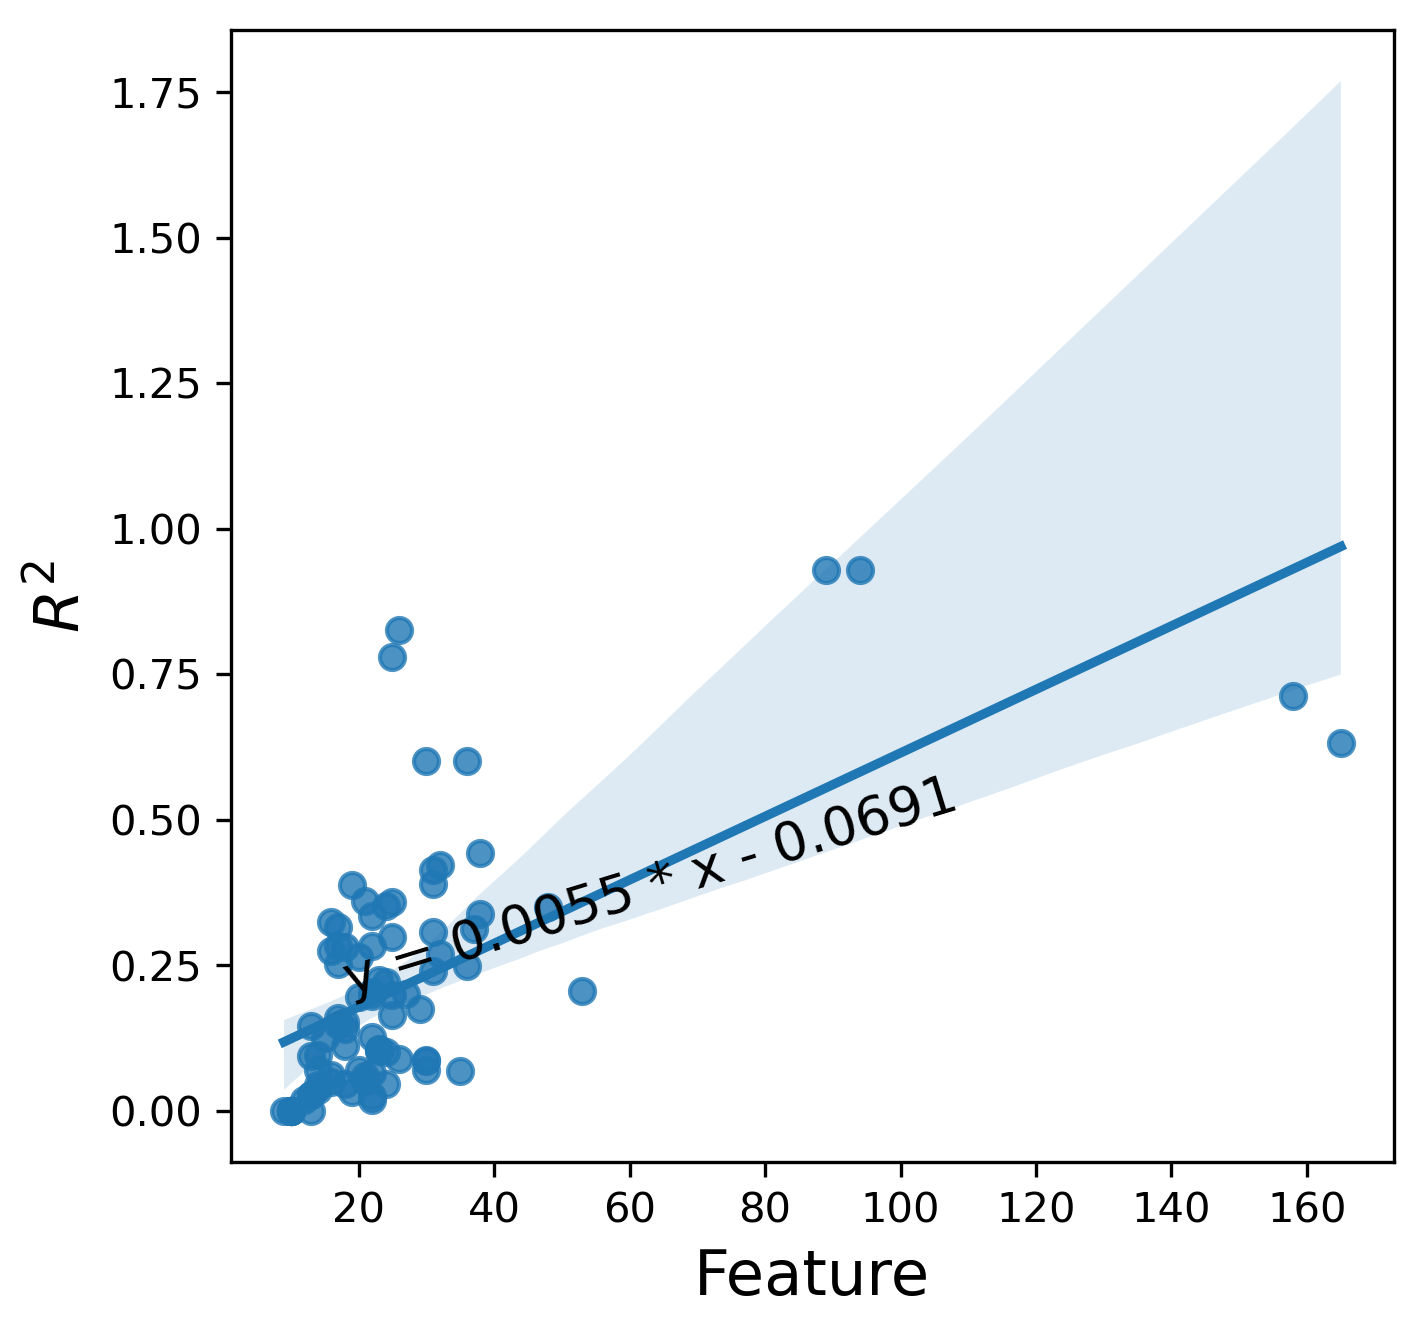

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     R2   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     56.94
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           4.34e-11
Time:                        16:22:29   Log-Likelihood:                 34.068
No. Observations:                  88   AIC:                            -64.14
Df Residuals:                      86   BIC:                            -59.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0691      0.026      2.630      0.010       0.017       0.121
Feature        0.0055      0.001      7.546      0.000       0.004       0.007
==============================================================================
Omnibus:                       29.687   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.667
Skew:                           1.375   Prob(JB):                     9.95e-12
Kurtosis:                       5.502   Cond. No.                         53.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
fig = plt.figure(0, (5, 5), dpi=300)
p = sns.regplot(x="Feature", y="R2", data=result)
slope, intercept, r_value, p_value, std_err = stats.linregress(x=p.get_lines()[0].get_xdata(), y=p.get_lines()[0].get_ydata())
_ = plt.annotate('y = '+str(round(slope, 4))+' * x - '+str(round(abs(intercept), 4)), (17, 0.2), fontsize=13, rotation=17)

_ = plt.xlabel('Feature', fontsize=15)
_ = plt.ylabel('$R^2$', fontsize=15)
plt.savefig('../Results/2.Feature_lineFit.pdf',bbox_inches = 'tight')
_ = plt.show()

X = result['Feature']
X = sm.add_constant(X)
y = result['R2']
est=sm.OLS(y, X)
est=est.fit()
est.summary()

In [14]:
feature_set = list(feature_set)
index = list(importances.keys())
result = pd.DataFrame(np.zeros((len(importances), len(feature_set))), index=index, columns=feature_set)
for p in index:
    for l in feature_set:
        result.loc[p, l] = importances[p].get(l, np.nan)
count = (result.shape[0]-result.isnull().sum()).sort_values(ascending=False)
count.loc[count>5]

age_category_adult                   70
age                                  68
gender_male                          63
BMI                                  48
age_category_senior                  48
age_category_child                   19
country_USA                          18
disease_subtype_NA                   16
country_CHN                          15
country_EST                          15
antibiotics_family_cephalosporins    15
country_FIN                          15
hba1c                                15
age_category_newborn                 14
antibiotics_family_penicillins       12
hla_dqa12                            12
hla_drb12                            12
hla_drb11                            12
hla_dqa11                            12
country_RUS                          12
hdl                                  11
ldl                                  11
triglycerides                        11
ever_smoker_no                       11
cholesterol                          10


,age,gender_male,BMI,country_USA,country_FIN,country_EST,country_CHN,hba1c,hdl,ldl,...,triglycerides,smoker_yes,cholesterol,creatinine,fobt_yes,hscrp,treatment_metformin,brinkman_index,fasting_glucose,alcohol_numeric
08,0.000000,0.005709,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09,0.003249,0.050123,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


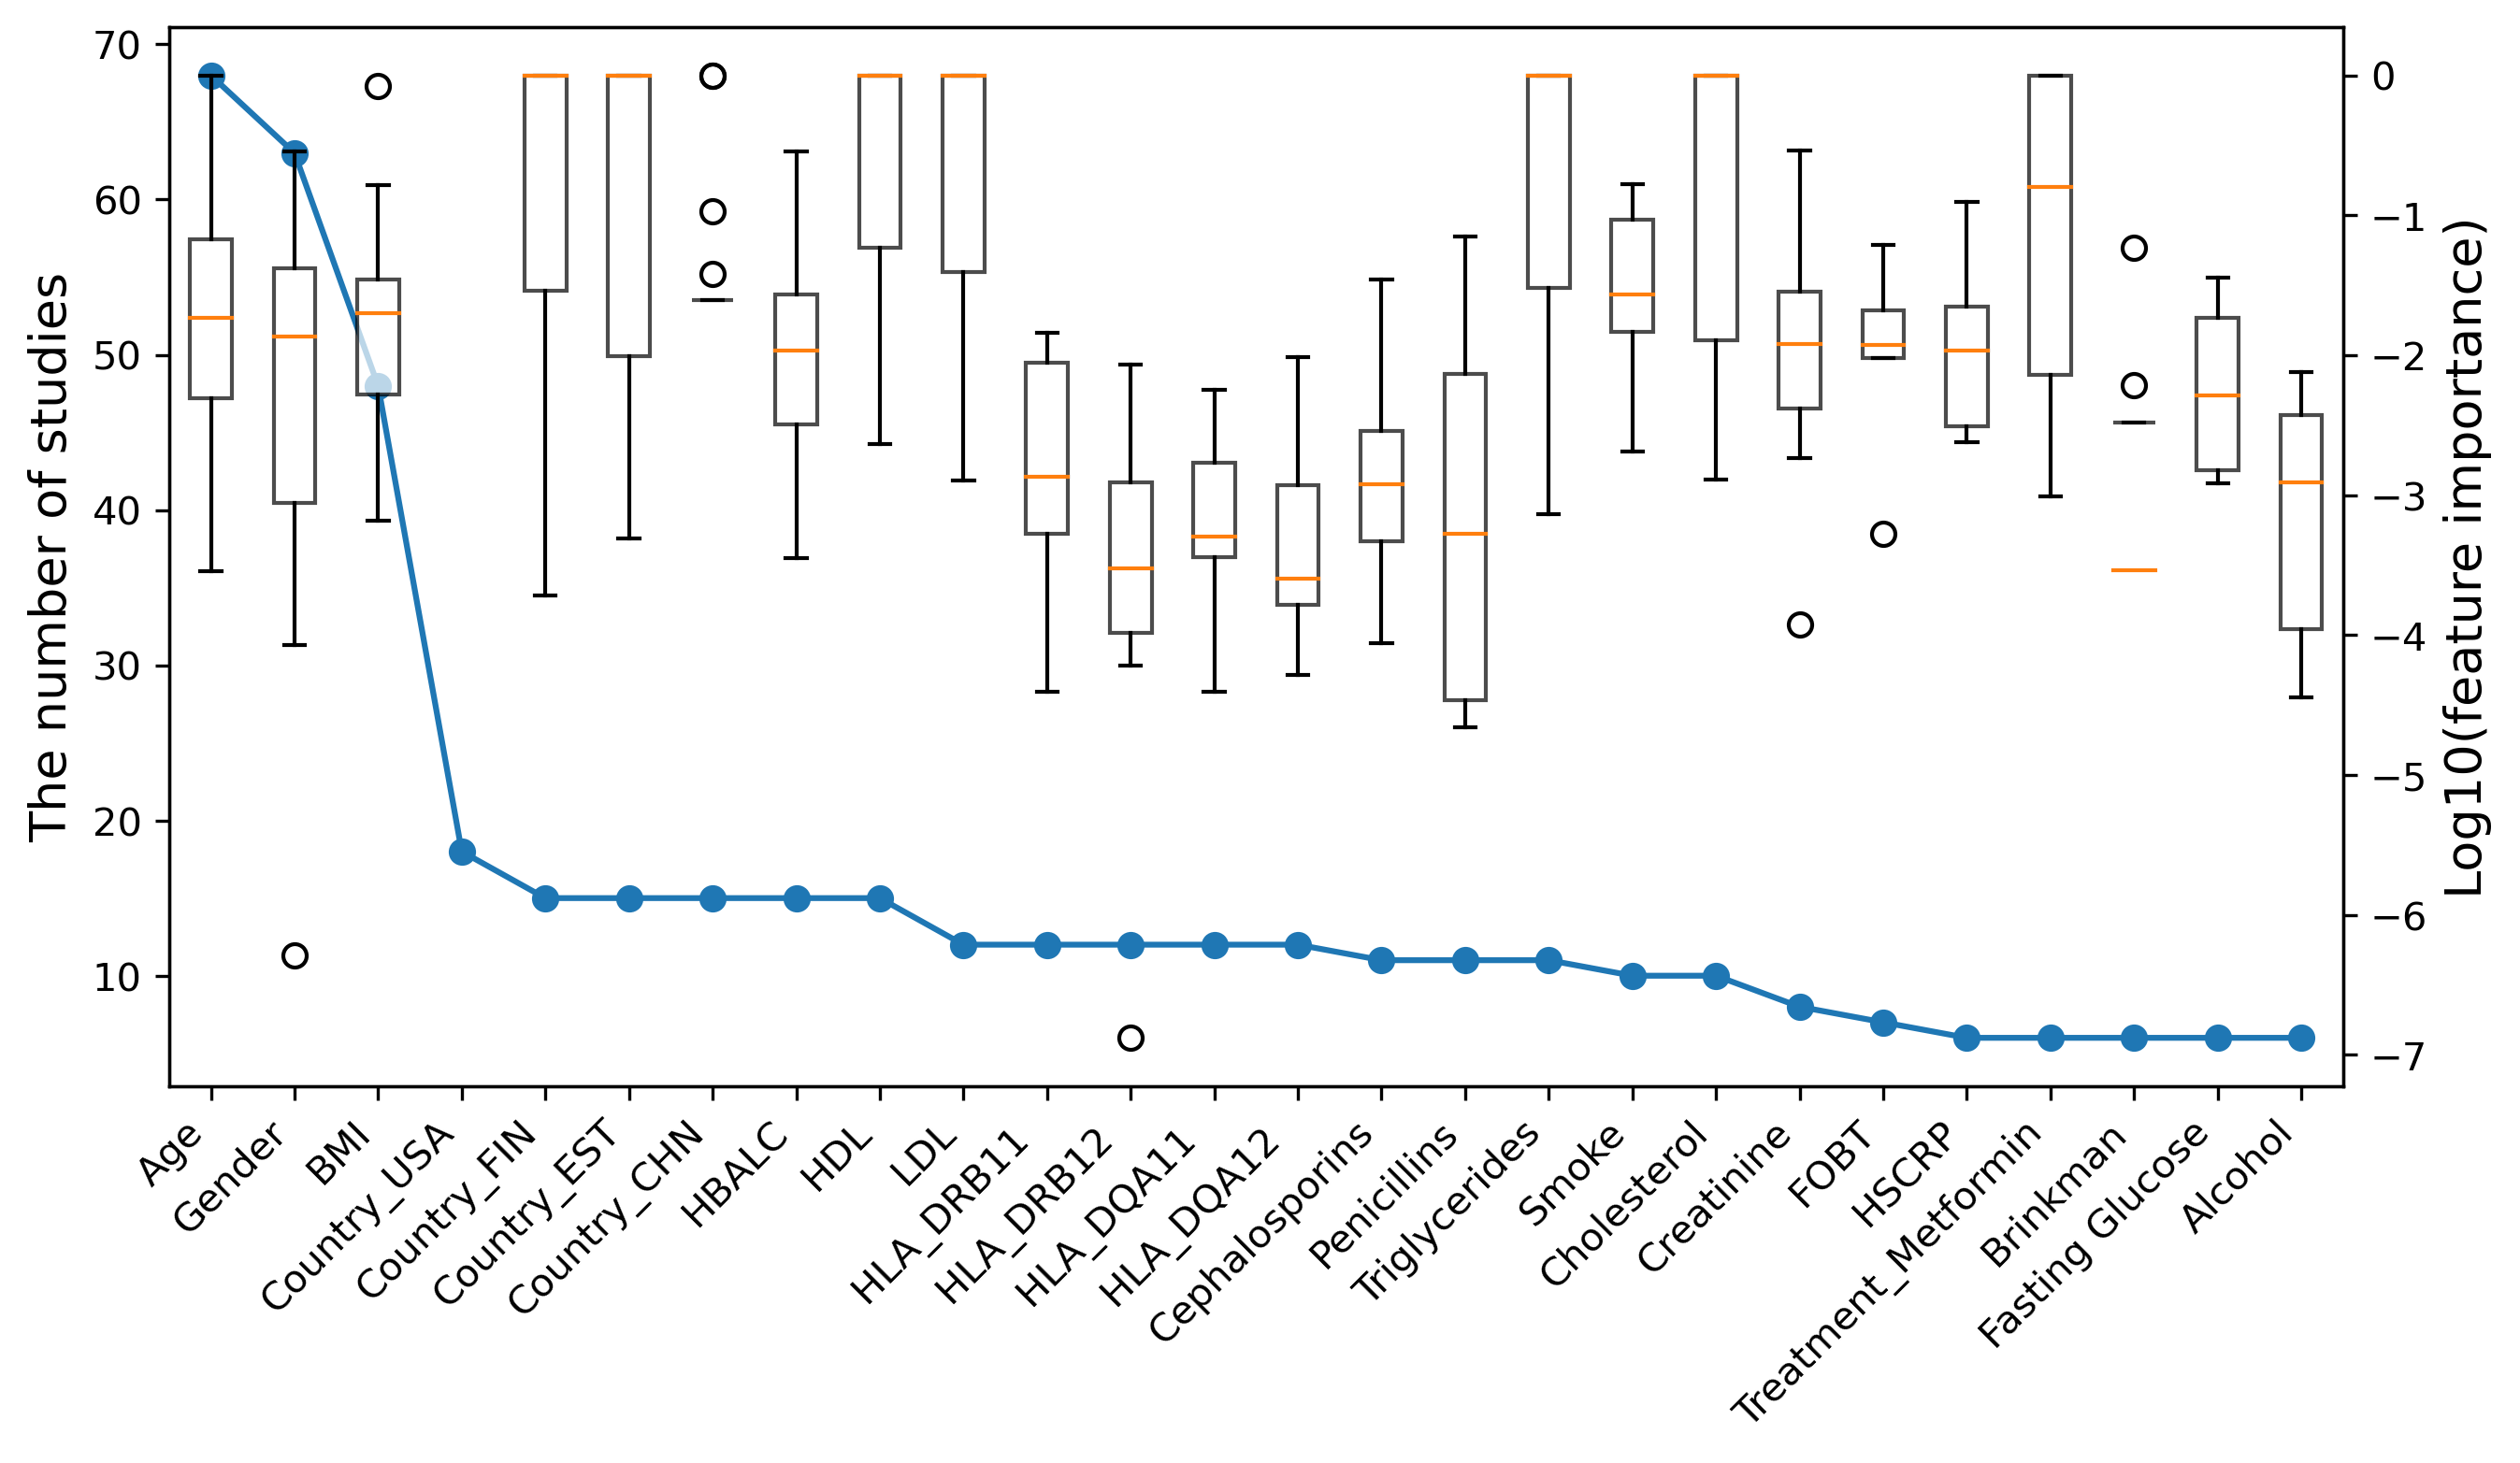

In [15]:
features = np.array([('age', 'Age'),('gender_male', 'Gender'), ('BMI', 'BMI'), 
                     ('country_USA','Country_USA'),('country_FIN','Country_FIN'),('country_EST','Country_EST'),('country_CHN','Country_CHN'),
                     ('hba1c','HBA1C'),('hdl', 'HDL'), ('ldl', 'LDL'), 
                     ('hla_drb11','HLA_DRB11 '),('hla_drb12','HLA_DRB12 '),
                     ('hla_dqa11','HLA_DQA11 '),('hla_dqa12','HLA_DQA12 '),
                     ('antibiotics_family_cephalosporins','Cephalosporins'),
                     ('antibiotics_family_penicillins','Penicillins'),
                     ('triglycerides','Triglycerides'),('smoker_yes','Smoke'),
                     ('cholesterol','Cholesterol'),('creatinine','Creatinine'),('fobt_yes','FOBT'),
                     ('hscrp','HSCRP'),('treatment_metformin','Treatment_Metformin'),
                     ('brinkman_index','Brinkman'),('fasting_glucose','Fasting Glucose'),('alcohol_numeric','Alcohol')])
result = result.loc[:, features[:,0]]
result.head(2)
result.columns = features[:, 1]
count = (result.shape[0]-result.isnull().sum()).sort_values(ascending=False)
#result.head(2)

plot_feature = features[:, 1][:]
fig = plt.figure(0, (10, 5), dpi=300)
ax = fig.add_subplot(111)
_ = plt.plot(np.arange(len(plot_feature))+1, count.values, '-', marker='o')
_ = plt.xticks(np.arange(len(plot_feature))+1, plot_feature, rotation=45, ha='right')
#_ = plt.yticks([5, 10, 15, 20], [5, 10, 15, 20])
_ = plt.ylabel('The number of studies', fontsize=13)

ax2 = ax.twinx()
bp = plt.boxplot([np.log10(np.clip(result[i].dropna(), 0, 1)) for i in plot_feature], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('white')
    patch.set_alpha(0.7)
_ = plt.xticks(np.arange(len(plot_feature))+1, plot_feature, rotation=45, ha='right')
_ = plt.ylabel('Log10(feature importance)', fontsize=13)
#plt.savefig('../Results/2.Feature_importance.pdf',bbox_inches = 'tight')
_ = plt.show()